# All Graphs Data Analysis (10-Node Graphs)

Comprehensive analysis of 10-node synthetic graphs with multiple motif instances and metadata tracking.

In [83]:
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## Data Loading

Load all graphs and metadata from the unified directory structure.

In [84]:
data_dir = Path('./data/all_graphs')
graphs_dir = data_dir / 'raw_graphs'
metadata_dir = data_dir / 'graph_motif_metadata'

def load_graph_with_metadata(graph_id):
    graph_path = graphs_dir / f'graph_{graph_id}.pkl'
    metadata_path = metadata_dir / f'graph_{graph_id}_metadata.csv'
    
    with open(graph_path, 'rb') as f:
        G = pickle.load(f)
    
    metadata = pd.read_csv(metadata_path, index_col=0)
    
    return G, metadata

# FIXED: Sort files numerically by extracting graph ID, not lexicographically
graph_files = sorted(graphs_dir.glob('graph_*.pkl'), 
                     key=lambda x: int(x.stem.split('_')[1]))
n_graphs = len(graph_files)

print(f"Found {n_graphs} graphs in {graphs_dir}")
print(f"Metadata files in {metadata_dir}")
print(f"\nFirst 5 files: {[f.name for f in graph_files[:5]]}")
print(f"Last 5 files: {[f.name for f in graph_files[-5:]]}")

Found 5000 graphs in data/all_graphs/raw_graphs
Metadata files in data/all_graphs/graph_motif_metadata

First 5 files: ['graph_0.pkl', 'graph_1.pkl', 'graph_2.pkl', 'graph_3.pkl', 'graph_4.pkl']
Last 5 files: ['graph_4995.pkl', 'graph_4996.pkl', 'graph_4997.pkl', 'graph_4998.pkl', 'graph_4999.pkl']


## Load Sample Graphs for Initial Exploration

In [85]:
sample_ids = [0, 1000, 2000, 3000, 4000]
sample_graphs = {}
sample_metadata = {}

for graph_id in sample_ids:
    if graph_id < n_graphs:
        G, meta = load_graph_with_metadata(graph_id)
        sample_graphs[graph_id] = G
        sample_metadata[graph_id] = meta
        
        print(f"\nGraph {graph_id}:")
        print(f"  Nodes: {len(G.nodes())}")
        print(f"  Edges: {len(G.edges())}")
        if 'motif_type' in G.graph:
            print(f"  Type: Single-motif ({G.graph['motif_type']})")
        elif 'motif_composition' in G.graph:
            print(f"  Type: Mixed-motif ({G.graph['motif_composition']})")
        print(f"  Metadata shape: {meta.shape}")


Graph 0:
  Nodes: 10
  Edges: 9
  Type: Single-motif (feedforward_loop)
  Metadata shape: (10, 4)

Graph 1000:
  Nodes: 10
  Edges: 10
  Type: Single-motif (feedback_loop)
  Metadata shape: (10, 4)

Graph 2000:
  Nodes: 10
  Edges: 6
  Type: Single-motif (single_input_module)
  Metadata shape: (10, 4)

Graph 3000:
  Nodes: 10
  Edges: 6
  Type: Single-motif (cascade)
  Metadata shape: (10, 4)

Graph 4000:
  Nodes: 10
  Edges: 25
  Type: Mixed-motif (['single_input_module', 'feedforward_loop', 'feedback_loop'])
  Metadata shape: (10, 4)


## Overview Statistics

Analyze the full dataset to understand graph distribution.

In [86]:
motif_types = ['feedforward_loop', 'feedback_loop', 'single_input_module', 'cascade']

single_motif_counts = defaultdict(int)
mixed_motif_count = 0

for graph_file in tqdm(graph_files[:500], desc="Scanning graphs"):
    graph_id = int(graph_file.stem.split('_')[1])
    G, _ = load_graph_with_metadata(graph_id)
    
    if 'motif_type' in G.graph:
        single_motif_counts[G.graph['motif_type']] += 1
    elif 'motif_composition' in G.graph:
        mixed_motif_count += 1

print("\nGraph Type Distribution (first 500):")
print(f"Single-motif graphs:")
for motif, count in single_motif_counts.items():
    print(f"  {motif}: {count}")
print(f"Mixed-motif graphs: {mixed_motif_count}")

Scanning graphs: 100%|██████████| 500/500 [00:00<00:00, 1031.73it/s]


Graph Type Distribution (first 500):
Single-motif graphs:
  feedforward_loop: 500
Mixed-motif graphs: 0


---
# Metadata Analysis

Analyze the motif membership metadata across all graphs.

In [87]:
def analyze_metadata(metadata_df):
    analysis = {
        'total_nodes': len(metadata_df),
        'motif_nodes': {},
        'isolated_nodes': 0,
        'multi_motif_nodes': 0
    }
    
    for motif in motif_types:
        analysis['motif_nodes'][motif] = metadata_df[motif].sum()
    
    node_motif_counts = metadata_df.sum(axis=1)
    analysis['isolated_nodes'] = (node_motif_counts == 0).sum()
    analysis['multi_motif_nodes'] = (node_motif_counts > 1).sum()
    
    return analysis

sample_analysis = {}
for graph_id, meta in sample_metadata.items():
    sample_analysis[graph_id] = analyze_metadata(meta)

for graph_id, analysis in sample_analysis.items():
    print(f"\nGraph {graph_id}:")
    print(f"  Total nodes: {analysis['total_nodes']}")
    print(f"  Isolated nodes: {analysis['isolated_nodes']}")
    print(f"  Multi-motif nodes: {analysis['multi_motif_nodes']}")
    print(f"  Motif breakdown: {analysis['motif_nodes']}")


Graph 0:
  Total nodes: 10
  Isolated nodes: 1
  Multi-motif nodes: 0
  Motif breakdown: {'feedforward_loop': 9, 'feedback_loop': 0, 'single_input_module': 0, 'cascade': 0}

Graph 1000:
  Total nodes: 10
  Isolated nodes: 0
  Multi-motif nodes: 0
  Motif breakdown: {'feedforward_loop': 0, 'feedback_loop': 10, 'single_input_module': 0, 'cascade': 0}

Graph 2000:
  Total nodes: 10
  Isolated nodes: 2
  Multi-motif nodes: 0
  Motif breakdown: {'feedforward_loop': 0, 'feedback_loop': 0, 'single_input_module': 8, 'cascade': 0}

Graph 3000:
  Total nodes: 10
  Isolated nodes: 2
  Multi-motif nodes: 0
  Motif breakdown: {'feedforward_loop': 0, 'feedback_loop': 0, 'single_input_module': 0, 'cascade': 8}

Graph 4000:
  Total nodes: 10
  Isolated nodes: 0
  Multi-motif nodes: 0
  Motif breakdown: {'feedforward_loop': 3, 'feedback_loop': 2, 'single_input_module': 5, 'cascade': 0}


## Visualize Metadata Patterns

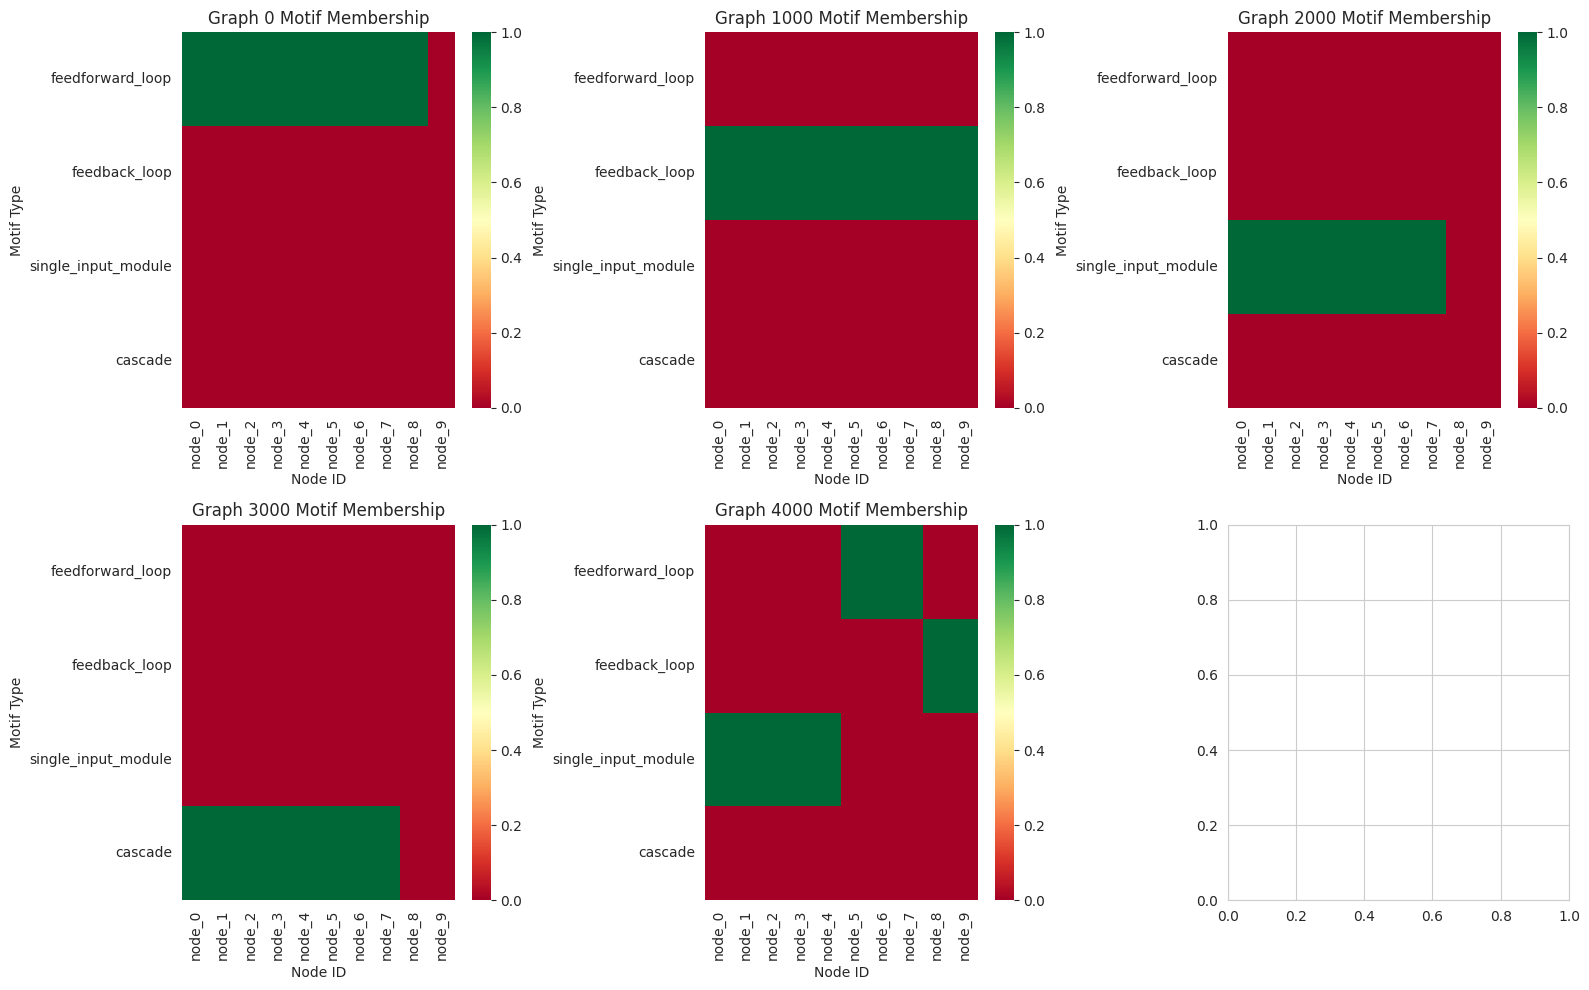

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (graph_id, meta) in enumerate(list(sample_metadata.items())[:6]):
    sns.heatmap(meta.T, cmap='RdYlGn', cbar=True, 
                xticklabels=True, yticklabels=True,
                ax=axes[idx], vmin=0, vmax=1)
    axes[idx].set_title(f'Graph {graph_id} Motif Membership')
    axes[idx].set_xlabel('Node ID')
    axes[idx].set_ylabel('Motif Type')

plt.tight_layout()
plt.show()

---
# Single-Motif Graph Analysis

Detailed analysis of graphs containing multiple instances of the same motif type.

## Feedforward Loop Graphs

In [89]:
def load_motif_type_graphs(motif_type, n_samples=100):
    graphs = []
    metadata_list = []
    
    for graph_file in tqdm(graph_files, desc=f"Loading {motif_type}"):
        if len(graphs) >= n_samples:
            break
        
        graph_id = int(graph_file.stem.split('_')[1])
        G, meta = load_graph_with_metadata(graph_id)
        
        if 'motif_type' in G.graph and G.graph['motif_type'] == motif_type:
            graphs.append(G)
            metadata_list.append(meta)
    
    return graphs, metadata_list

ffl_graphs, ffl_metadata = load_motif_type_graphs('feedforward_loop', n_samples=100)

Loading feedforward_loop:   2%|▏         | 100/5000 [00:00<00:05, 921.32it/s]


In [90]:
def extract_graph_stats(graphs, metadata_list):
    stats = {
        'num_nodes': [],
        'num_edges': [],
        'density': [],
        'isolated_nodes': [],
        'motif_nodes': [],
        'edge_weights': []
    }
    
    for G, meta in zip(graphs, metadata_list):
        stats['num_nodes'].append(len(G.nodes()))
        stats['num_edges'].append(len(G.edges()))
        stats['density'].append(nx.density(G))
        
        isolated = (meta.sum(axis=1) == 0).sum()
        stats['isolated_nodes'].append(isolated)
        stats['motif_nodes'].append(10 - isolated)
        
        weights = [data['weight'] for _, _, data in G.edges(data=True)]
        stats['edge_weights'].extend(weights)
    
    return stats

ffl_stats = extract_graph_stats(ffl_graphs, ffl_metadata)

print(f"\nFeedforward Loop Statistics (n={len(ffl_graphs)}):")
print(f"  Nodes per graph: {np.mean(ffl_stats['num_nodes']):.1f} ± {np.std(ffl_stats['num_nodes']):.1f}")
print(f"  Edges per graph: {np.mean(ffl_stats['num_edges']):.1f} ± {np.std(ffl_stats['num_edges']):.1f}")
print(f"  Isolated nodes per graph: {np.mean(ffl_stats['isolated_nodes']):.1f} ± {np.std(ffl_stats['isolated_nodes']):.1f}")
print(f"  Motif nodes per graph: {np.mean(ffl_stats['motif_nodes']):.1f} ± {np.std(ffl_stats['motif_nodes']):.1f}")
print(f"  Graph density: {np.mean(ffl_stats['density']):.3f} ± {np.std(ffl_stats['density']):.3f}")


Feedforward Loop Statistics (n=100):
  Nodes per graph: 10.0 ± 0.0
  Edges per graph: 9.0 ± 0.0
  Isolated nodes per graph: 1.0 ± 0.0
  Motif nodes per graph: 9.0 ± 0.0
  Graph density: 0.100 ± 0.000


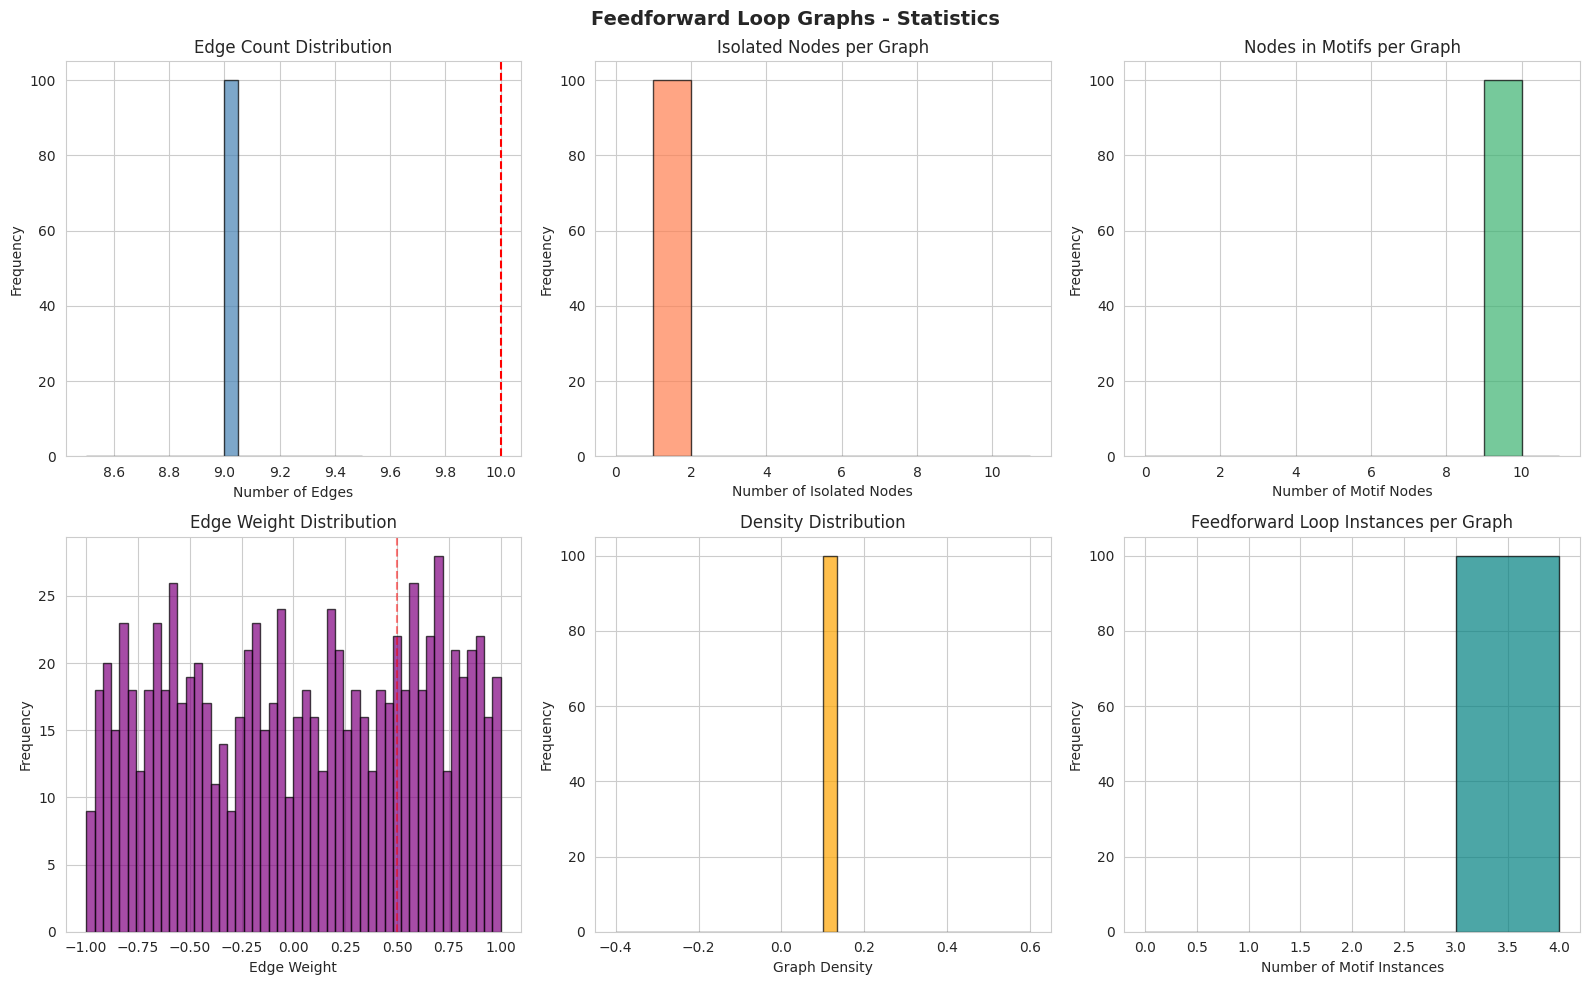

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].hist(ffl_stats['num_edges'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Number of Edges')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Edge Count Distribution')
axes[0, 0].axvline(10, color='red', linestyle='--', label='All graphs = 10 nodes')

axes[0, 1].hist(ffl_stats['isolated_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Number of Isolated Nodes')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Isolated Nodes per Graph')

axes[0, 2].hist(ffl_stats['motif_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[0, 2].set_xlabel('Number of Motif Nodes')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Nodes in Motifs per Graph')

axes[1, 0].hist(ffl_stats['edge_weights'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_xlabel('Edge Weight')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Edge Weight Distribution')
axes[1, 0].axvline(0.5, color='red', linestyle='--', alpha=0.5)

axes[1, 1].hist(ffl_stats['density'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Graph Density')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Density Distribution')

motif_per_graph = [m // 3 for m in ffl_stats['motif_nodes']]
axes[1, 2].hist(motif_per_graph, bins=range(5), edgecolor='black', alpha=0.7, color='teal')
axes[1, 2].set_xlabel('Number of Motif Instances')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Feedforward Loop Instances per Graph')

plt.suptitle('Feedforward Loop Graphs - Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Sample Graph Visualizations

/tmp/ipykernel_3495417/1389782402.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/1389782402.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/1389782402.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/1389782402.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/1389782402.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and wil

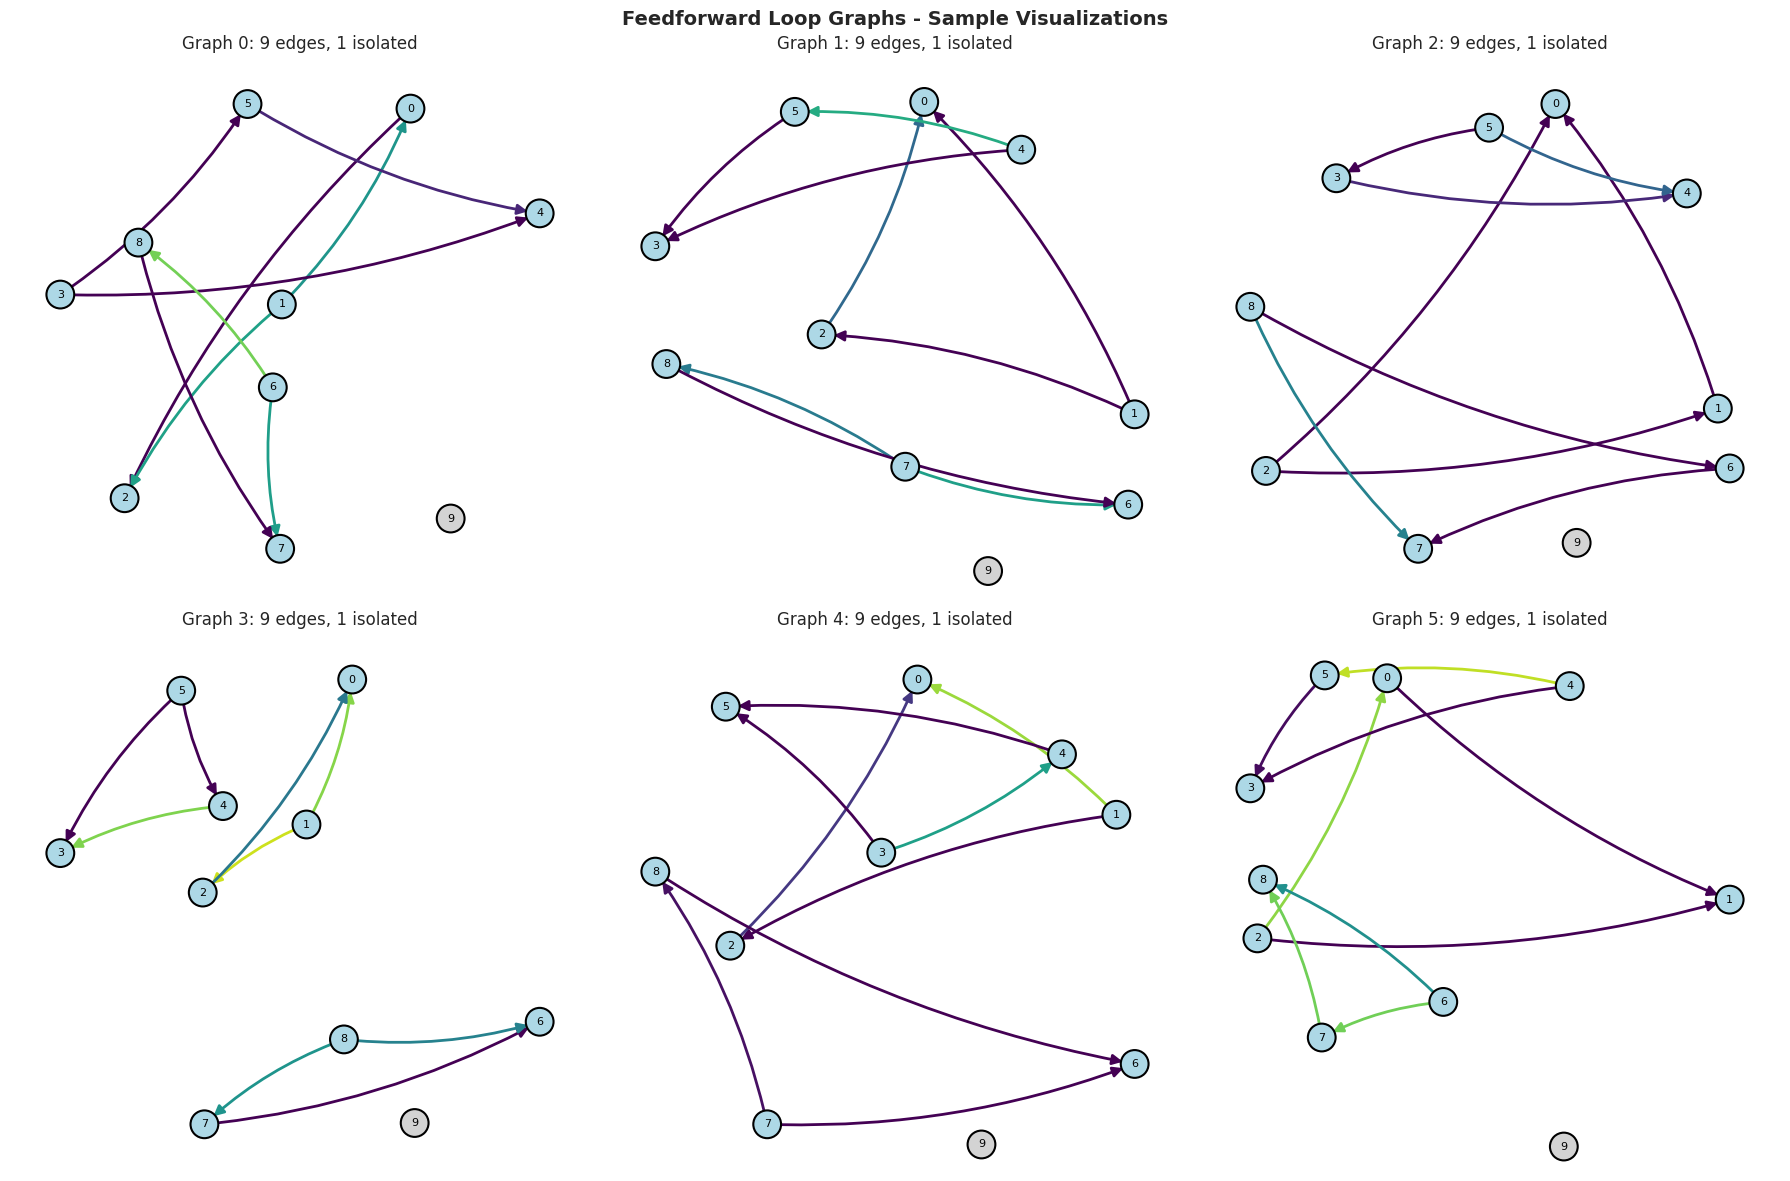

In [92]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx in range(6):
    if idx < len(ffl_graphs):
        G = ffl_graphs[idx]
        meta = ffl_metadata[idx]
        
        pos = nx.spring_layout(G, seed=42, k=0.8)
        
        node_colors = ['lightblue' if meta.iloc[i].sum() > 0 else 'lightgray' 
                      for i in range(len(G.nodes()))]
        
        edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
        
        nx.draw_networkx_nodes(G, pos, node_size=400, node_color=node_colors,
                              edgecolors='black', linewidths=1.5, ax=axes[idx])
        
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                              edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1,
                              width=2, arrows=True, arrowsize=15,
                              connectionstyle='arc3,rad=0.1', ax=axes[idx])
        
        nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[idx])
        
        isolated = (meta.sum(axis=1) == 0).sum()
        axes[idx].set_title(f'Graph {idx}: {len(G.edges())} edges, {isolated} isolated')
        axes[idx].axis('off')

plt.suptitle('Feedforward Loop Graphs - Sample Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/paper_figures/feedforward_loop_sample_graphs.png')
plt.show()

## Expression Simulation

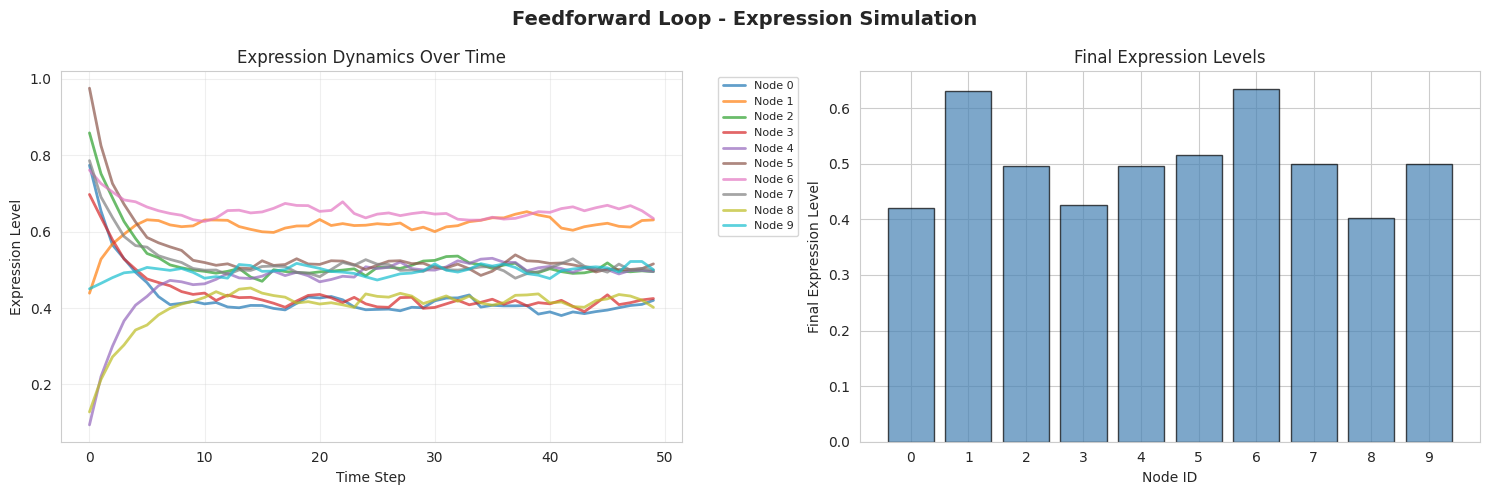

In [93]:
def simulate_expression(W, steps=50, gamma=0.3, noise_std=0.01, seed=42):
    rng = np.random.default_rng(seed)
    n_nodes = W.shape[0]
    x = rng.uniform(0, 1, size=n_nodes)
    trajectory = np.zeros((steps, n_nodes))
    trajectory[0] = x
    
    for t in range(1, steps):
        weighted_input = W @ x
        sigmoid_input = 1.0 / (1.0 + np.exp(-np.clip(weighted_input, -10, 10)))
        noise = rng.normal(0, noise_std, size=n_nodes)
        x = (1 - gamma) * x + gamma * sigmoid_input + noise
        x = np.clip(x, 0, 1)
        trajectory[t] = x
    
    return x, trajectory

sample_G = ffl_graphs[0]
W = nx.to_numpy_array(sample_G, weight='weight')
final_expr, trajectory = simulate_expression(W, steps=50)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for node in range(len(final_expr)):
    axes[0].plot(trajectory[:, node], linewidth=2, alpha=0.7, label=f'Node {node}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Expression Level')
axes[0].set_title('Expression Dynamics Over Time')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3)

axes[1].bar(range(len(final_expr)), final_expr, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Node ID')
axes[1].set_ylabel('Final Expression Level')
axes[1].set_title('Final Expression Levels')
axes[1].set_xticks(range(len(final_expr)))

plt.suptitle('Feedforward Loop - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/paper_figures/feedforward_loop_expression_simulation.png')
plt.show()

---
## Feedback Loop Graphs

In [94]:
fbl_graphs, fbl_metadata = load_motif_type_graphs('feedback_loop', n_samples=100)

Loading feedback_loop:  22%|██▏       | 1100/5000 [00:01<00:03, 1021.66it/s]


In [95]:
fbl_stats = extract_graph_stats(fbl_graphs, fbl_metadata)

print(f"\nFeedback Loop Statistics (n={len(fbl_graphs)}):")
print(f"  Nodes per graph: {np.mean(fbl_stats['num_nodes']):.1f} ± {np.std(fbl_stats['num_nodes']):.1f}")
print(f"  Edges per graph: {np.mean(fbl_stats['num_edges']):.1f} ± {np.std(fbl_stats['num_edges']):.1f}")
print(f"  Isolated nodes per graph: {np.mean(fbl_stats['isolated_nodes']):.1f} ± {np.std(fbl_stats['isolated_nodes']):.1f}")
print(f"  Motif nodes per graph: {np.mean(fbl_stats['motif_nodes']):.1f} ± {np.std(fbl_stats['motif_nodes']):.1f}")
print(f"  Graph density: {np.mean(fbl_stats['density']):.3f} ± {np.std(fbl_stats['density']):.3f}")


Feedback Loop Statistics (n=100):
  Nodes per graph: 10.0 ± 0.0
  Edges per graph: 10.0 ± 0.0
  Isolated nodes per graph: 0.0 ± 0.0
  Motif nodes per graph: 10.0 ± 0.0
  Graph density: 0.111 ± 0.000


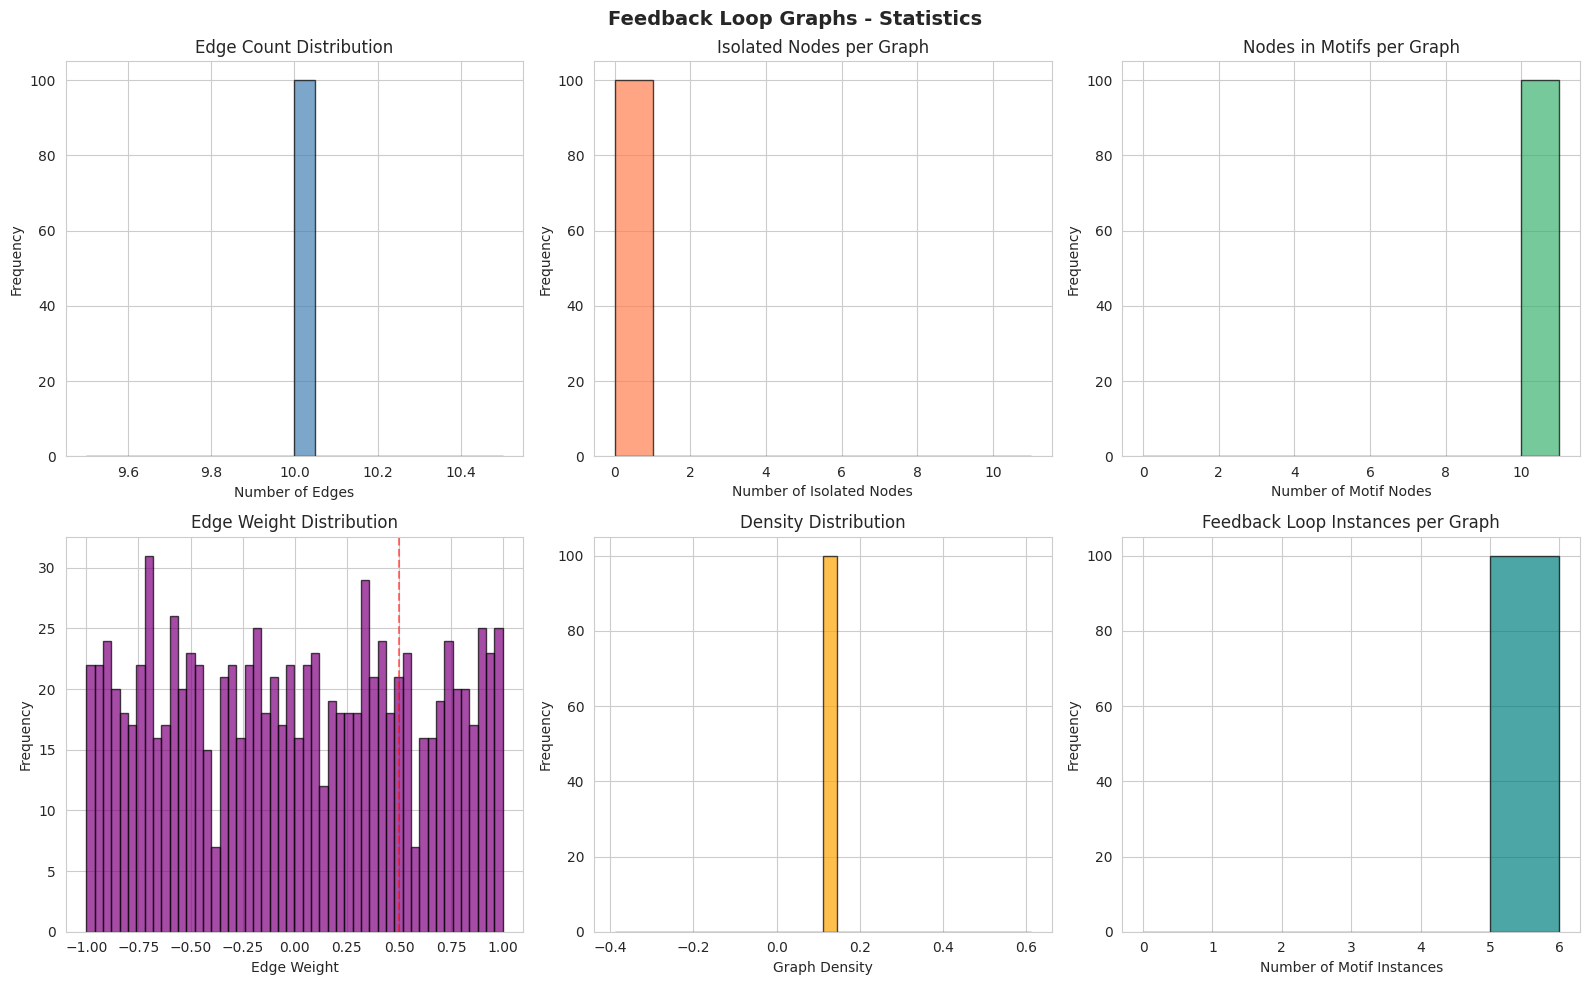

In [96]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].hist(fbl_stats['num_edges'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Number of Edges')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Edge Count Distribution')

axes[0, 1].hist(fbl_stats['isolated_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Number of Isolated Nodes')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Isolated Nodes per Graph')

axes[0, 2].hist(fbl_stats['motif_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[0, 2].set_xlabel('Number of Motif Nodes')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Nodes in Motifs per Graph')

axes[1, 0].hist(fbl_stats['edge_weights'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_xlabel('Edge Weight')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Edge Weight Distribution')
axes[1, 0].axvline(0.5, color='red', linestyle='--', alpha=0.5)

axes[1, 1].hist(fbl_stats['density'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Graph Density')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Density Distribution')

# Feedback loops have 2 nodes per instance
motif_per_graph = [m // 2 for m in fbl_stats['motif_nodes']]
axes[1, 2].hist(motif_per_graph, bins=range(7), edgecolor='black', alpha=0.7, color='teal')
axes[1, 2].set_xlabel('Number of Motif Instances')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Feedback Loop Instances per Graph')

plt.suptitle('Feedback Loop Graphs - Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3495417/3519883900.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/3519883900.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/3519883900.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/3519883900.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/3519883900.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and wil

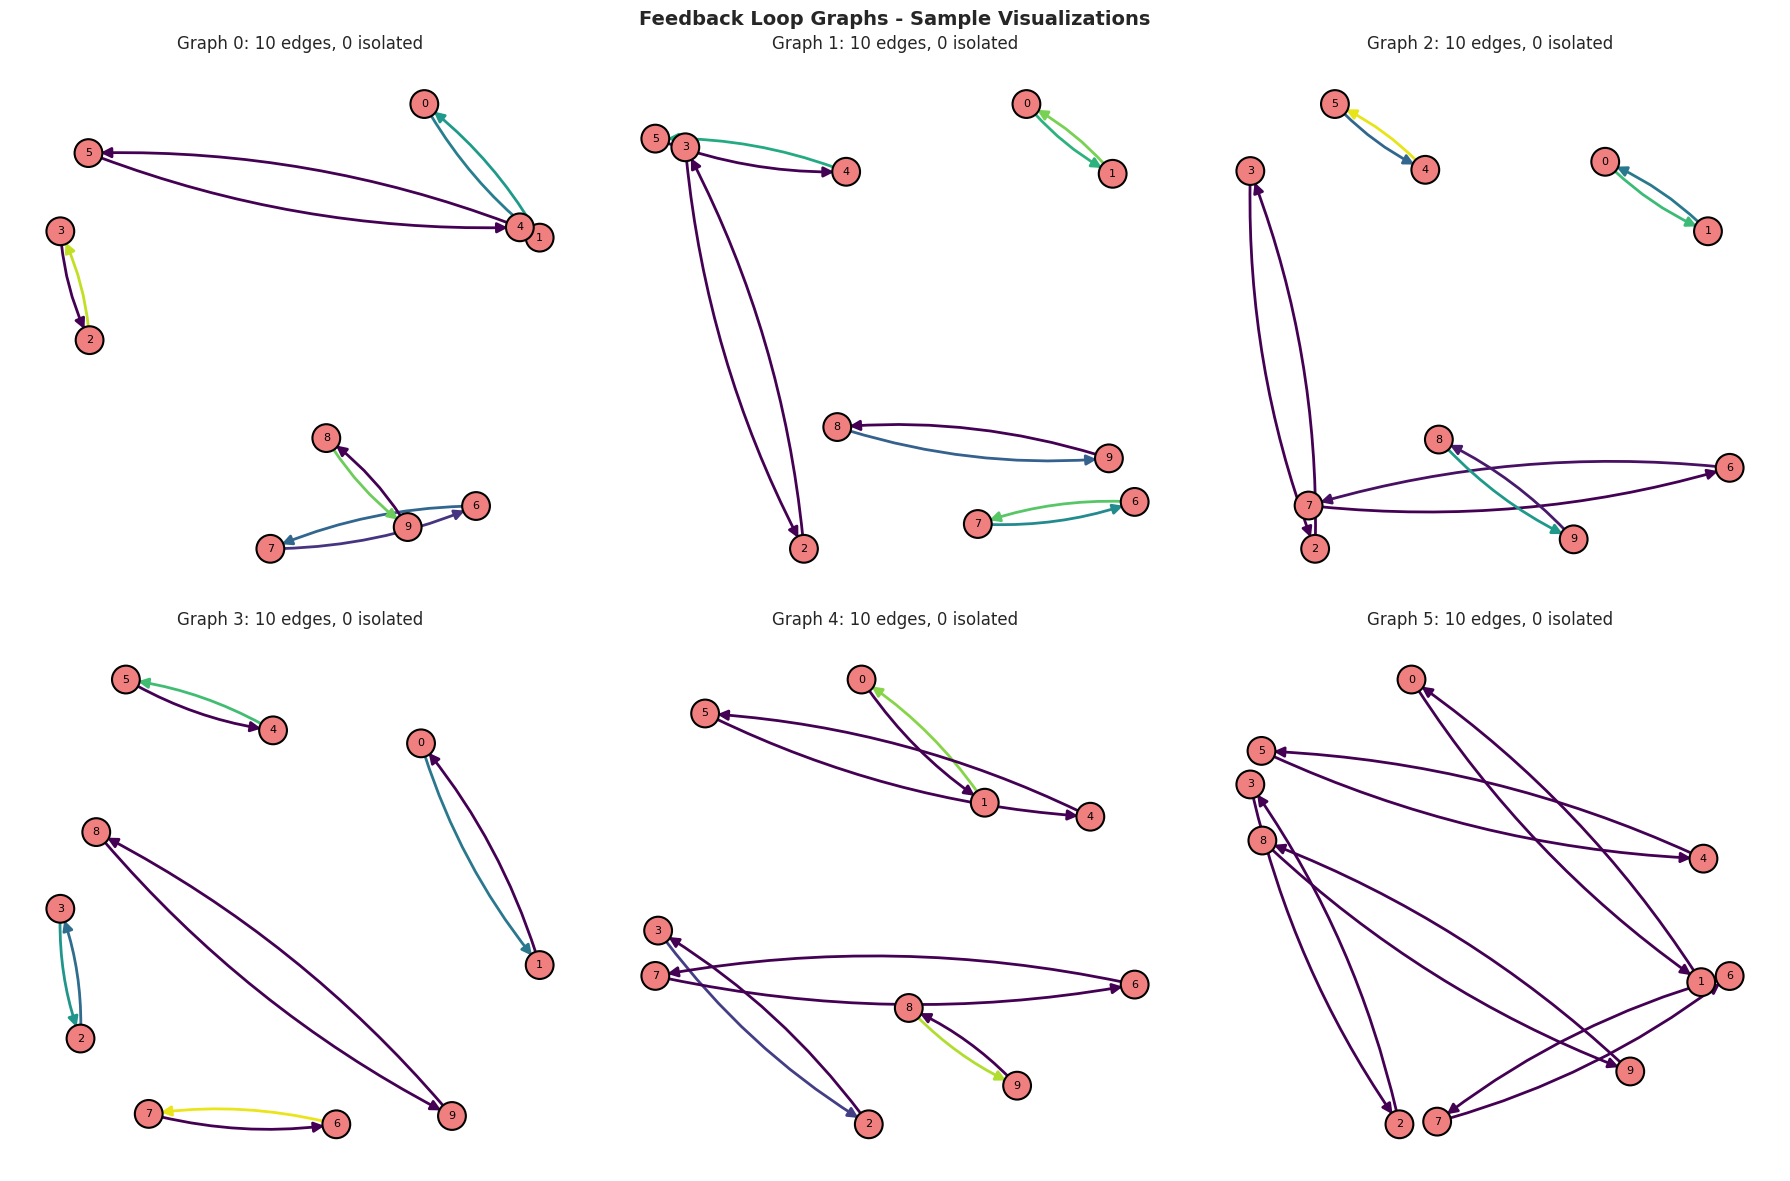

In [97]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx in range(6):
    if idx < len(fbl_graphs):
        G = fbl_graphs[idx]
        meta = fbl_metadata[idx]
        
        pos = nx.spring_layout(G, seed=42, k=0.8)
        
        node_colors = ['lightcoral' if meta.iloc[i].sum() > 0 else 'lightgray' 
                      for i in range(len(G.nodes()))]
        
        edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
        
        nx.draw_networkx_nodes(G, pos, node_size=400, node_color=node_colors,
                              edgecolors='black', linewidths=1.5, ax=axes[idx])
        
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                              edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1,
                              width=2, arrows=True, arrowsize=15,
                              connectionstyle='arc3,rad=0.1', ax=axes[idx])
        
        nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[idx])
        
        isolated = (meta.sum(axis=1) == 0).sum()
        axes[idx].set_title(f'Graph {idx}: {len(G.edges())} edges, {isolated} isolated')
        axes[idx].axis('off')

plt.suptitle('Feedback Loop Graphs - Sample Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/paper_figures/feedback_loop_sample_graphs.png')
plt.show()

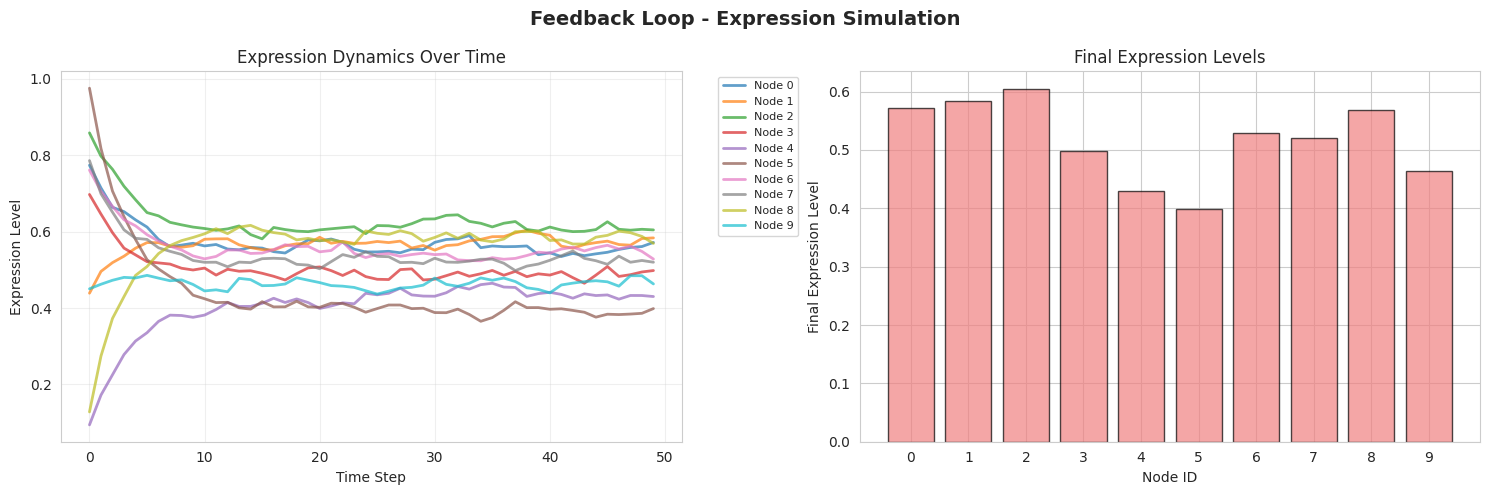

In [98]:
sample_fbl_G = fbl_graphs[0]
W_fbl = nx.to_numpy_array(sample_fbl_G, weight='weight')
final_expr_fbl, trajectory_fbl = simulate_expression(W_fbl, steps=50)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for node in range(len(final_expr_fbl)):
    axes[0].plot(trajectory_fbl[:, node], linewidth=2, alpha=0.7, label=f'Node {node}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Expression Level')
axes[0].set_title('Expression Dynamics Over Time')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3)

axes[1].bar(range(len(final_expr_fbl)), final_expr_fbl, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Node ID')
axes[1].set_ylabel('Final Expression Level')
axes[1].set_title('Final Expression Levels')
axes[1].set_xticks(range(len(final_expr_fbl)))

plt.suptitle('Feedback Loop - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/paper_figures/feedback_loop_expression_simulation.png')
plt.show()

---
## Single Input Module Graphs

In [99]:
sim_graphs, sim_metadata = load_motif_type_graphs('single_input_module', n_samples=100)

Loading single_input_module:  42%|████▏     | 2100/5000 [00:02<00:02, 1001.55it/s]


In [100]:
sim_stats = extract_graph_stats(sim_graphs, sim_metadata)

print(f"\nSingle Input Module Statistics (n={len(sim_graphs)}):")
print(f"  Nodes per graph: {np.mean(sim_stats['num_nodes']):.1f} ± {np.std(sim_stats['num_nodes']):.1f}")
print(f"  Edges per graph: {np.mean(sim_stats['num_edges']):.1f} ± {np.std(sim_stats['num_edges']):.1f}")
print(f"  Isolated nodes per graph: {np.mean(sim_stats['isolated_nodes']):.1f} ± {np.std(sim_stats['isolated_nodes']):.1f}")
print(f"  Motif nodes per graph: {np.mean(sim_stats['motif_nodes']):.1f} ± {np.std(sim_stats['motif_nodes']):.1f}")
print(f"  Graph density: {np.mean(sim_stats['density']):.3f} ± {np.std(sim_stats['density']):.3f}")


Single Input Module Statistics (n=100):
  Nodes per graph: 10.0 ± 0.0
  Edges per graph: 7.0 ± 0.7
  Isolated nodes per graph: 1.0 ± 0.7
  Motif nodes per graph: 9.0 ± 0.7
  Graph density: 0.078 ± 0.008


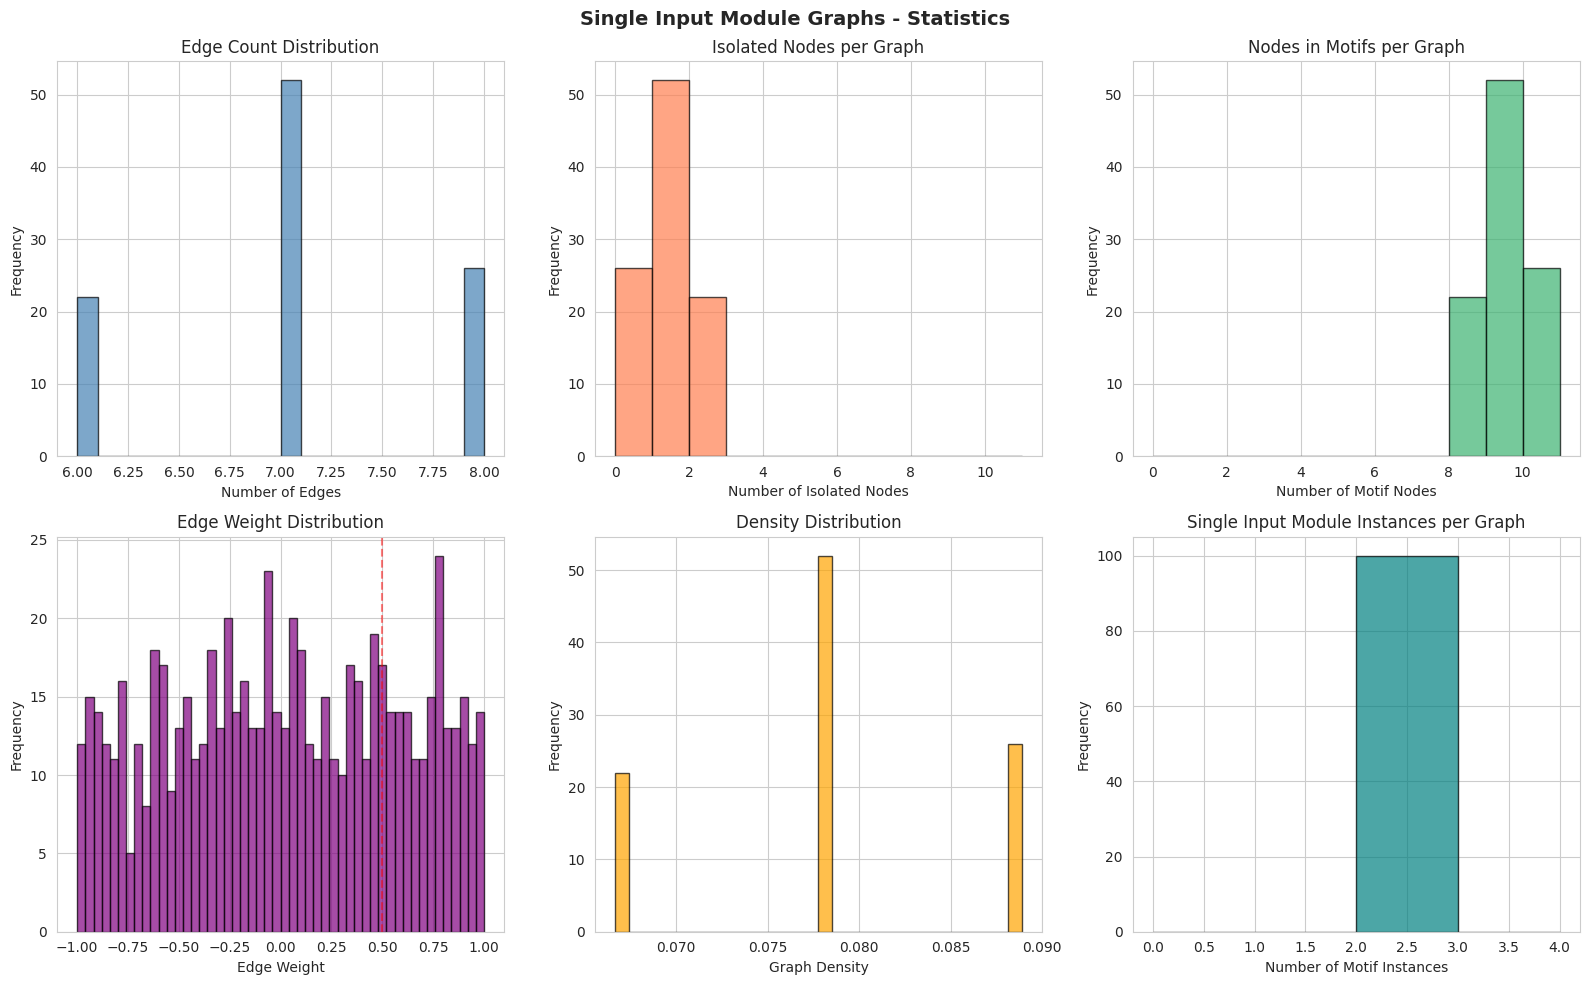

In [101]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].hist(sim_stats['num_edges'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Number of Edges')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Edge Count Distribution')

axes[0, 1].hist(sim_stats['isolated_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Number of Isolated Nodes')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Isolated Nodes per Graph')

axes[0, 2].hist(sim_stats['motif_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[0, 2].set_xlabel('Number of Motif Nodes')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Nodes in Motifs per Graph')

axes[1, 0].hist(sim_stats['edge_weights'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_xlabel('Edge Weight')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Edge Weight Distribution')
axes[1, 0].axvline(0.5, color='red', linestyle='--', alpha=0.5)

axes[1, 1].hist(sim_stats['density'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Graph Density')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Density Distribution')

# Single input modules have 4 nodes per instance (1 input + 3 outputs)
motif_per_graph = [m // 4 for m in sim_stats['motif_nodes']]
axes[1, 2].hist(motif_per_graph, bins=range(5), edgecolor='black', alpha=0.7, color='teal')
axes[1, 2].set_xlabel('Number of Motif Instances')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Single Input Module Instances per Graph')

plt.suptitle('Single Input Module Graphs - Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3495417/1274164533.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/1274164533.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/1274164533.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/1274164533.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/1274164533.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and wil

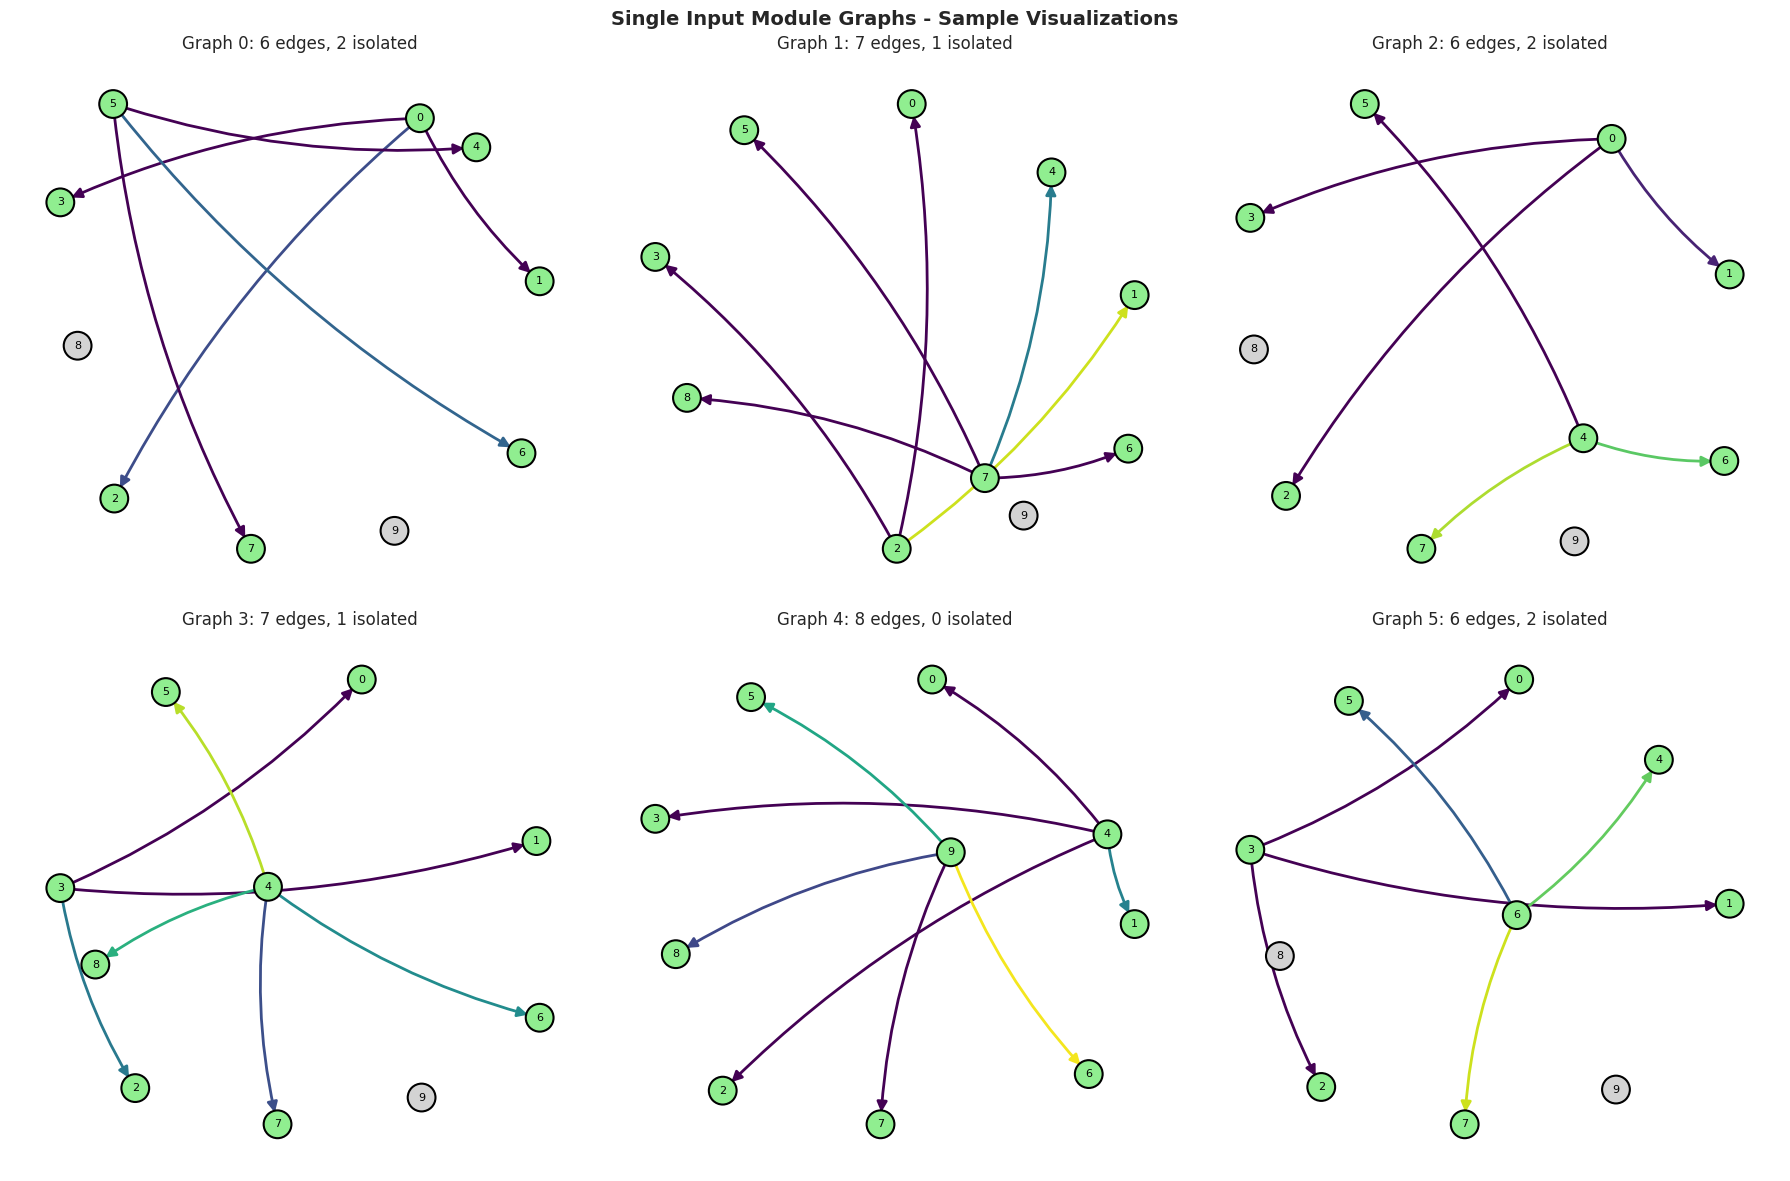

In [102]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx in range(6):
    if idx < len(sim_graphs):
        G = sim_graphs[idx]
        meta = sim_metadata[idx]
        
        pos = nx.spring_layout(G, seed=42, k=0.8)
        
        node_colors = ['lightgreen' if meta.iloc[i].sum() > 0 else 'lightgray' 
                      for i in range(len(G.nodes()))]
        
        edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
        
        nx.draw_networkx_nodes(G, pos, node_size=400, node_color=node_colors,
                              edgecolors='black', linewidths=1.5, ax=axes[idx])
        
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                              edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1,
                              width=2, arrows=True, arrowsize=15,
                              connectionstyle='arc3,rad=0.1', ax=axes[idx])
        
        nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[idx])
        
        isolated = (meta.sum(axis=1) == 0).sum()
        axes[idx].set_title(f'Graph {idx}: {len(G.edges())} edges, {isolated} isolated')
        axes[idx].axis('off')

plt.suptitle('Single Input Module Graphs - Sample Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/paper_figures/single_input_module_sample_graphs.png')
plt.show()

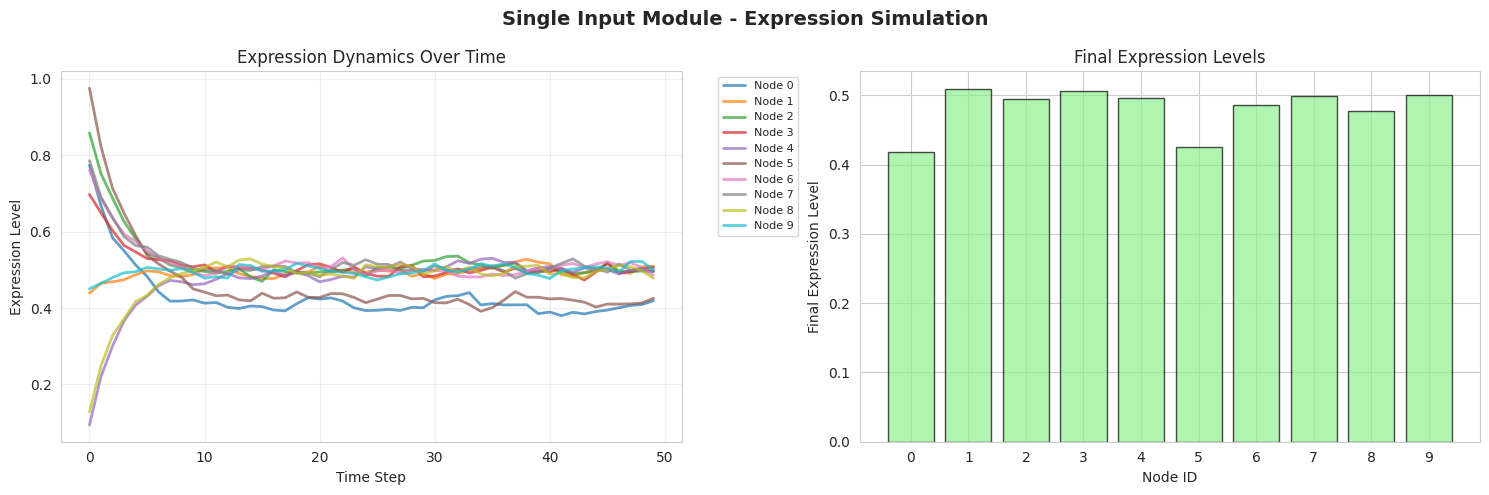

In [103]:
sample_sim_G = sim_graphs[0]
W_sim = nx.to_numpy_array(sample_sim_G, weight='weight')
final_expr_sim, trajectory_sim = simulate_expression(W_sim, steps=50)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for node in range(len(final_expr_sim)):
    axes[0].plot(trajectory_sim[:, node], linewidth=2, alpha=0.7, label=f'Node {node}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Expression Level')
axes[0].set_title('Expression Dynamics Over Time')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3)

axes[1].bar(range(len(final_expr_sim)), final_expr_sim, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Node ID')
axes[1].set_ylabel('Final Expression Level')
axes[1].set_title('Final Expression Levels')
axes[1].set_xticks(range(len(final_expr_sim)))

plt.suptitle('Single Input Module - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/paper_figures/single_input_module_expression_simulation.png')
plt.show()

---
## Cascade Graphs

In [104]:
cascade_graphs, cascade_metadata = load_motif_type_graphs('cascade', n_samples=100)

Loading cascade:  62%|██████▏   | 3100/5000 [00:03<00:01, 1003.77it/s]


In [105]:
cascade_stats = extract_graph_stats(cascade_graphs, cascade_metadata)

print(f"\nCascade Statistics (n={len(cascade_graphs)}):")
print(f"  Nodes per graph: {np.mean(cascade_stats['num_nodes']):.1f} ± {np.std(cascade_stats['num_nodes']):.1f}")
print(f"  Edges per graph: {np.mean(cascade_stats['num_edges']):.1f} ± {np.std(cascade_stats['num_edges']):.1f}")
print(f"  Isolated nodes per graph: {np.mean(cascade_stats['isolated_nodes']):.1f} ± {np.std(cascade_stats['isolated_nodes']):.1f}")
print(f"  Motif nodes per graph: {np.mean(cascade_stats['motif_nodes']):.1f} ± {np.std(cascade_stats['motif_nodes']):.1f}")
print(f"  Graph density: {np.mean(cascade_stats['density']):.3f} ± {np.std(cascade_stats['density']):.3f}")


Cascade Statistics (n=100):
  Nodes per graph: 10.0 ± 0.0
  Edges per graph: 6.0 ± 0.0
  Isolated nodes per graph: 2.0 ± 0.0
  Motif nodes per graph: 8.0 ± 0.0
  Graph density: 0.067 ± 0.000


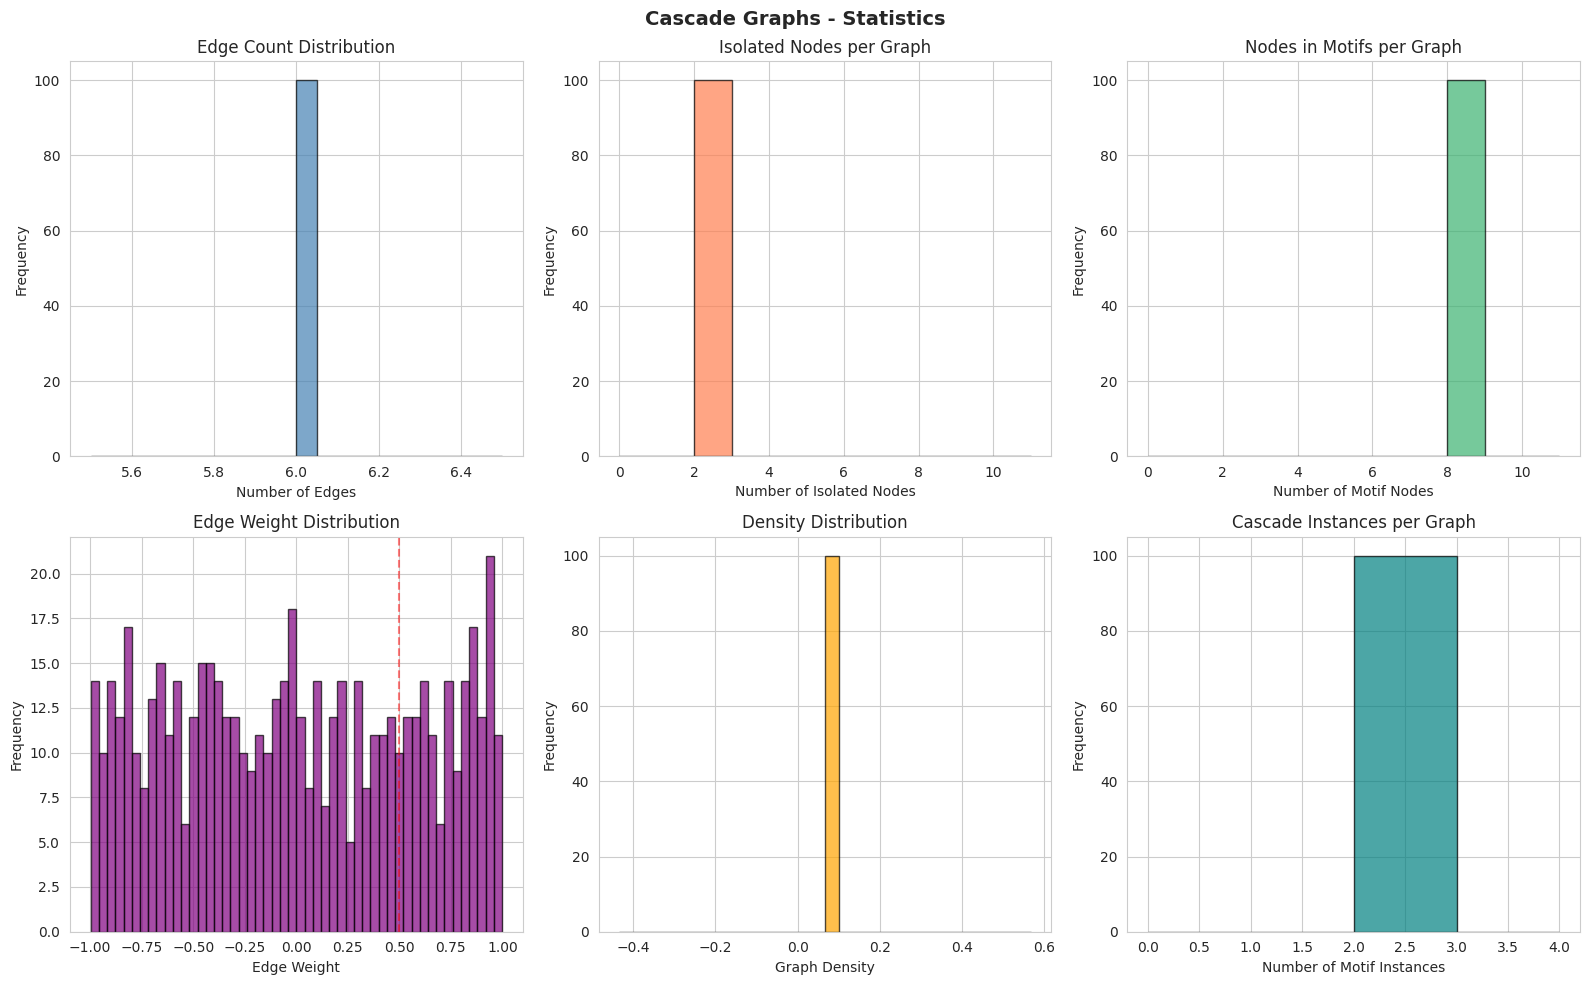

In [106]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].hist(cascade_stats['num_edges'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Number of Edges')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Edge Count Distribution')

axes[0, 1].hist(cascade_stats['isolated_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Number of Isolated Nodes')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Isolated Nodes per Graph')

axes[0, 2].hist(cascade_stats['motif_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[0, 2].set_xlabel('Number of Motif Nodes')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Nodes in Motifs per Graph')

axes[1, 0].hist(cascade_stats['edge_weights'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_xlabel('Edge Weight')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Edge Weight Distribution')
axes[1, 0].axvline(0.5, color='red', linestyle='--', alpha=0.5)

axes[1, 1].hist(cascade_stats['density'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Graph Density')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Density Distribution')

# Cascades have 4 nodes per instance (linear chain)
motif_per_graph = [m // 4 for m in cascade_stats['motif_nodes']]
axes[1, 2].hist(motif_per_graph, bins=range(5), edgecolor='black', alpha=0.7, color='teal')
axes[1, 2].set_xlabel('Number of Motif Instances')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Cascade Instances per Graph')

plt.suptitle('Cascade Graphs - Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3495417/2851205448.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/2851205448.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/2851205448.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/2851205448.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/2851205448.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and wil

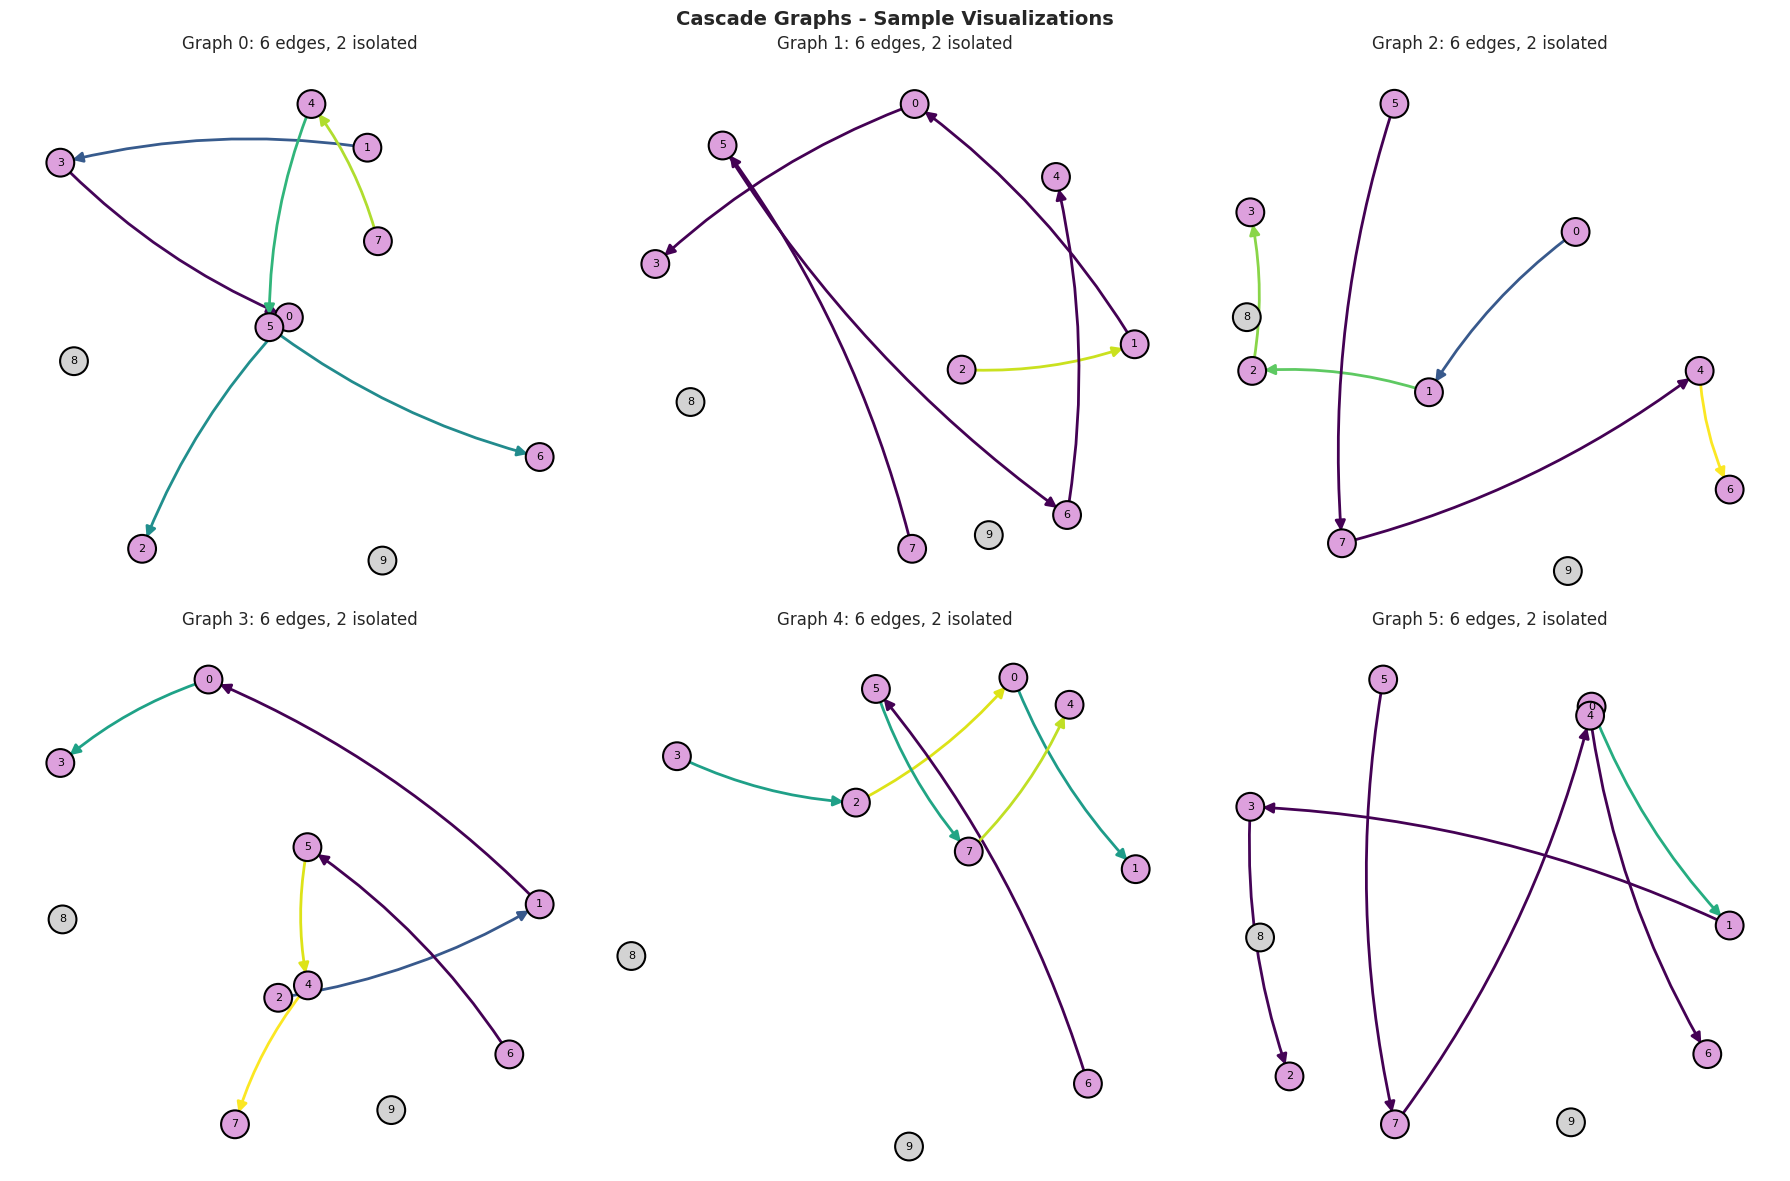

In [107]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx in range(6):
    if idx < len(cascade_graphs):
        G = cascade_graphs[idx]
        meta = cascade_metadata[idx]
        
        pos = nx.spring_layout(G, seed=42, k=0.8)
        
        node_colors = ['plum' if meta.iloc[i].sum() > 0 else 'lightgray' 
                      for i in range(len(G.nodes()))]
        
        edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
        
        nx.draw_networkx_nodes(G, pos, node_size=400, node_color=node_colors,
                              edgecolors='black', linewidths=1.5, ax=axes[idx])
        
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                              edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1,
                              width=2, arrows=True, arrowsize=15,
                              connectionstyle='arc3,rad=0.1', ax=axes[idx])
        
        nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[idx])
        
        isolated = (meta.sum(axis=1) == 0).sum()
        axes[idx].set_title(f'Graph {idx}: {len(G.edges())} edges, {isolated} isolated')
        axes[idx].axis('off')

plt.suptitle('Cascade Graphs - Sample Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/paper_figures/cascade_sample_graphs.png')
plt.show()

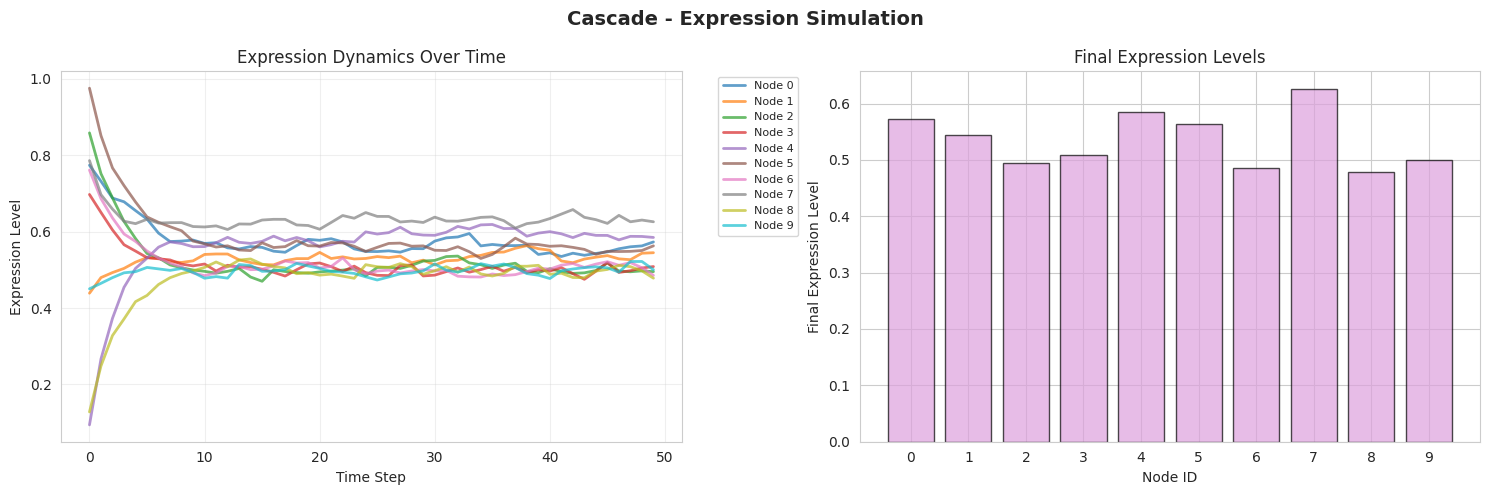

In [108]:
sample_cascade_G = cascade_graphs[0]
W_cascade = nx.to_numpy_array(sample_cascade_G, weight='weight')
final_expr_cascade, trajectory_cascade = simulate_expression(W_cascade, steps=50)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for node in range(len(final_expr_cascade)):
    axes[0].plot(trajectory_cascade[:, node], linewidth=2, alpha=0.7, label=f'Node {node}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Expression Level')
axes[0].set_title('Expression Dynamics Over Time')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3)

axes[1].bar(range(len(final_expr_cascade)), final_expr_cascade, color='plum', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Node ID')
axes[1].set_ylabel('Final Expression Level')
axes[1].set_title('Final Expression Levels')
axes[1].set_xticks(range(len(final_expr_cascade)))

plt.suptitle('Cascade - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/paper_figures/cascade_expression_simulation.png')
plt.show()

## Analyze All Single-Motif Types

In [109]:
all_single_motif_stats = {}

for motif_type in motif_types:
    graphs, metadata_list = load_motif_type_graphs(motif_type, n_samples=100)
    stats = extract_graph_stats(graphs, metadata_list)
    all_single_motif_stats[motif_type] = stats
    
    print(f"\n{motif_type.upper()}:")
    print(f"  Loaded {len(graphs)} graphs")
    print(f"  Avg edges: {np.mean(stats['num_edges']):.1f}")
    print(f"  Avg isolated nodes: {np.mean(stats['isolated_nodes']):.1f}")

Loading feedforward_loop:   2%|▏         | 100/5000 [00:00<00:05, 938.86it/s]



FEEDFORWARD_LOOP:
  Loaded 100 graphs
  Avg edges: 9.0
  Avg isolated nodes: 1.0


Loading feedback_loop:  22%|██▏       | 1100/5000 [00:01<00:03, 1021.23it/s]



FEEDBACK_LOOP:
  Loaded 100 graphs
  Avg edges: 10.0
  Avg isolated nodes: 0.0


Loading single_input_module:  42%|████▏     | 2100/5000 [00:02<00:02, 1027.13it/s]



SINGLE_INPUT_MODULE:
  Loaded 100 graphs
  Avg edges: 7.0
  Avg isolated nodes: 1.0


Loading cascade:  62%|██████▏   | 3100/5000 [00:03<00:01, 1017.45it/s]


CASCADE:
  Loaded 100 graphs
  Avg edges: 6.0
  Avg isolated nodes: 2.0


In [110]:
comparison_data = []

for motif_type, stats in all_single_motif_stats.items():
    for i in range(len(stats['num_edges'])):
        comparison_data.append({
            'motif': motif_type,
            'num_edges': stats['num_edges'][i],
            'isolated_nodes': stats['isolated_nodes'][i],
            'motif_nodes': stats['motif_nodes'][i],
            'density': stats['density'][i]
        })

comparison_df = pd.DataFrame(comparison_data)

/tmp/ipykernel_3495417/864300688.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_df, x='motif', y='num_edges', ax=axes[0, 0], palette='Set2')
/tmp/ipykernel_3495417/864300688.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_3495417/864300688.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_df, x='motif', y='isolated_nodes', ax=axes[0, 1], palette='Set2')
/tmp/ipykernel_3495417/864300688.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

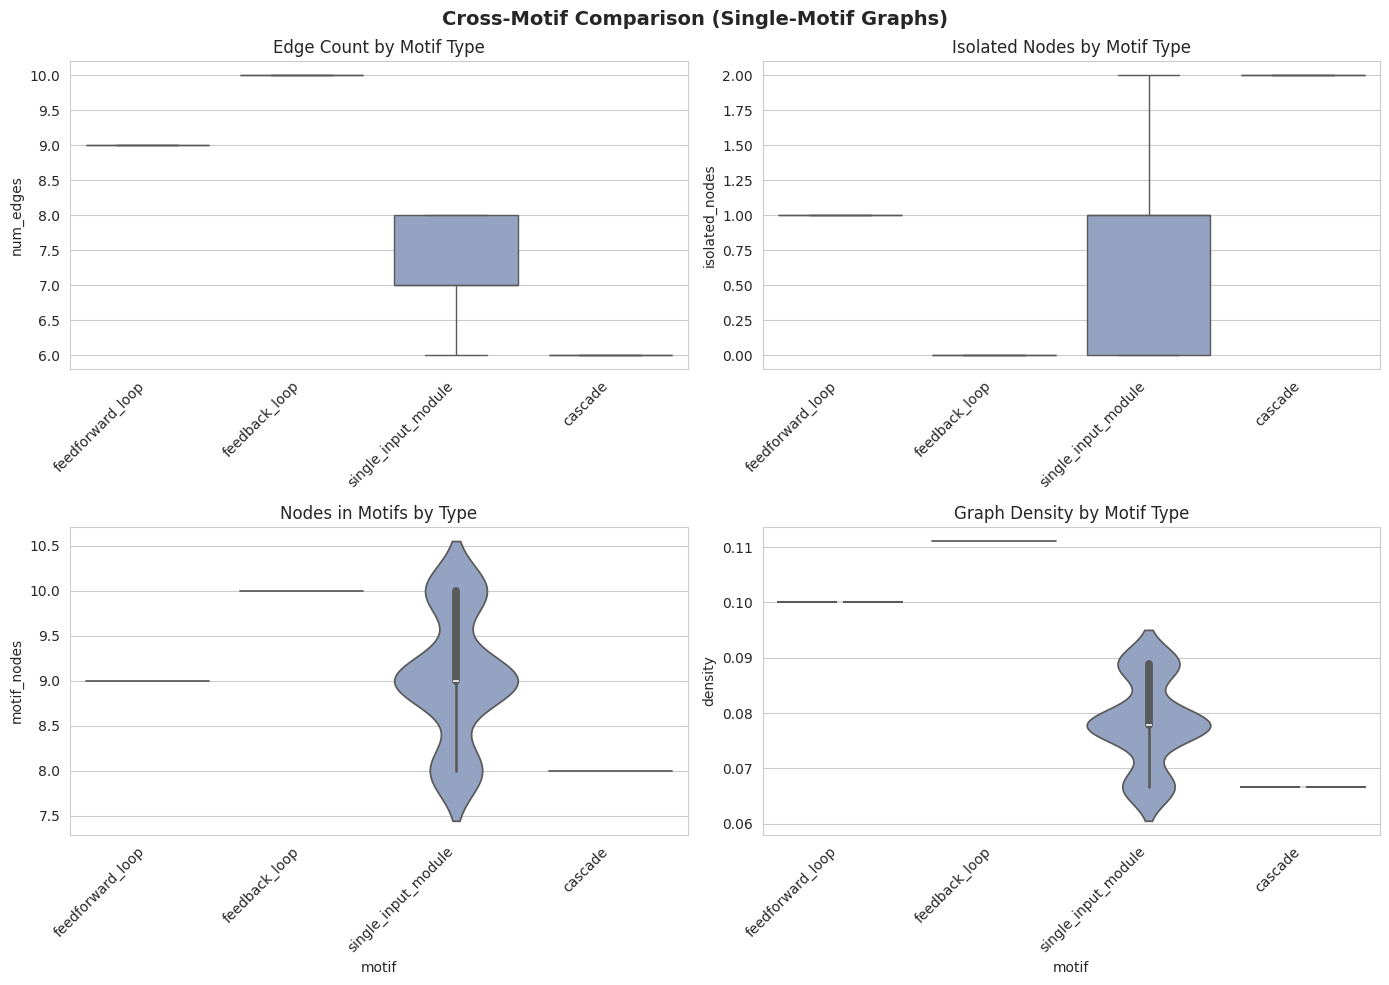

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(data=comparison_df, x='motif', y='num_edges', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].set_title('Edge Count by Motif Type')
axes[0, 0].set_xlabel('')

sns.boxplot(data=comparison_df, x='motif', y='isolated_nodes', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].set_title('Isolated Nodes by Motif Type')
axes[0, 1].set_xlabel('')

sns.violinplot(data=comparison_df, x='motif', y='motif_nodes', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].set_title('Nodes in Motifs by Type')

sns.violinplot(data=comparison_df, x='motif', y='density', ax=axes[1, 1], palette='Set2')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].set_title('Graph Density by Motif Type')

plt.suptitle('Cross-Motif Comparison (Single-Motif Graphs)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [112]:
print("\nSingle-Motif Graph Statistics Summary:")
summary = comparison_df.groupby('motif').agg({
    'num_edges': ['mean', 'std'],
    'isolated_nodes': ['mean', 'std'],
    'motif_nodes': ['mean', 'std'],
    'density': ['mean', 'std']
}).round(3)
print(summary)


Single-Motif Graph Statistics Summary:
                    num_edges        isolated_nodes        motif_nodes         \
                         mean    std           mean    std        mean    std   
motif                                                                           
cascade                  6.00  0.000           2.00  0.000        8.00  0.000   
feedback_loop           10.00  0.000           0.00  0.000       10.00  0.000   
feedforward_loop         9.00  0.000           1.00  0.000        9.00  0.000   
single_input_module      7.04  0.695           0.96  0.695        9.04  0.695   

                    density         
                       mean    std  
motif                               
cascade               0.067  0.000  
feedback_loop         0.111  0.000  
feedforward_loop      0.100  0.000  
single_input_module   0.078  0.008  


---
# Mixed-Motif Graph Analysis

Analysis of graphs containing multiple different motif types.

In [113]:
def load_mixed_motif_graphs(n_samples=200):
    graphs = []
    metadata_list = []
    compositions = []
    
    for graph_file in tqdm(graph_files, desc="Loading mixed-motif graphs"):
        if len(graphs) >= n_samples:
            break
        
        graph_id = int(graph_file.stem.split('_')[1])
        G, meta = load_graph_with_metadata(graph_id)
        
        if 'motif_composition' in G.graph:
            graphs.append(G)
            metadata_list.append(meta)
            compositions.append(G.graph['motif_composition'])
    
    return graphs, metadata_list, compositions

mixed_graphs, mixed_metadata, mixed_compositions = load_mixed_motif_graphs(n_samples=200)

print(f"Loaded {len(mixed_graphs)} mixed-motif graphs")

Loading mixed-motif graphs:  84%|████████▍ | 4200/5000 [00:04<00:00, 1040.16it/s]

Loaded 200 mixed-motif graphs


In [114]:
mixed_stats = extract_graph_stats(mixed_graphs, mixed_metadata)

print(f"\nMixed-Motif Graph Statistics (n={len(mixed_graphs)}):")
print(f"  Nodes per graph: {np.mean(mixed_stats['num_nodes']):.1f} ± {np.std(mixed_stats['num_nodes']):.1f}")
print(f"  Edges per graph: {np.mean(mixed_stats['num_edges']):.1f} ± {np.std(mixed_stats['num_edges']):.1f}")
print(f"  Isolated nodes per graph: {np.mean(mixed_stats['isolated_nodes']):.1f} ± {np.std(mixed_stats['isolated_nodes']):.1f}")
print(f"  Motif nodes per graph: {np.mean(mixed_stats['motif_nodes']):.1f} ± {np.std(mixed_stats['motif_nodes']):.1f}")
print(f"  Graph density: {np.mean(mixed_stats['density']):.3f} ± {np.std(mixed_stats['density']):.3f}")


Mixed-Motif Graph Statistics (n=200):
  Nodes per graph: 10.0 ± 0.0
  Edges per graph: 27.3 ± 4.8
  Isolated nodes per graph: 2.4 ± 1.5
  Motif nodes per graph: 7.6 ± 1.5
  Graph density: 0.303 ± 0.053


## Motif Composition Analysis

/tmp/ipykernel_3495417/672207836.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(motif_names, rotation=45, ha='right')


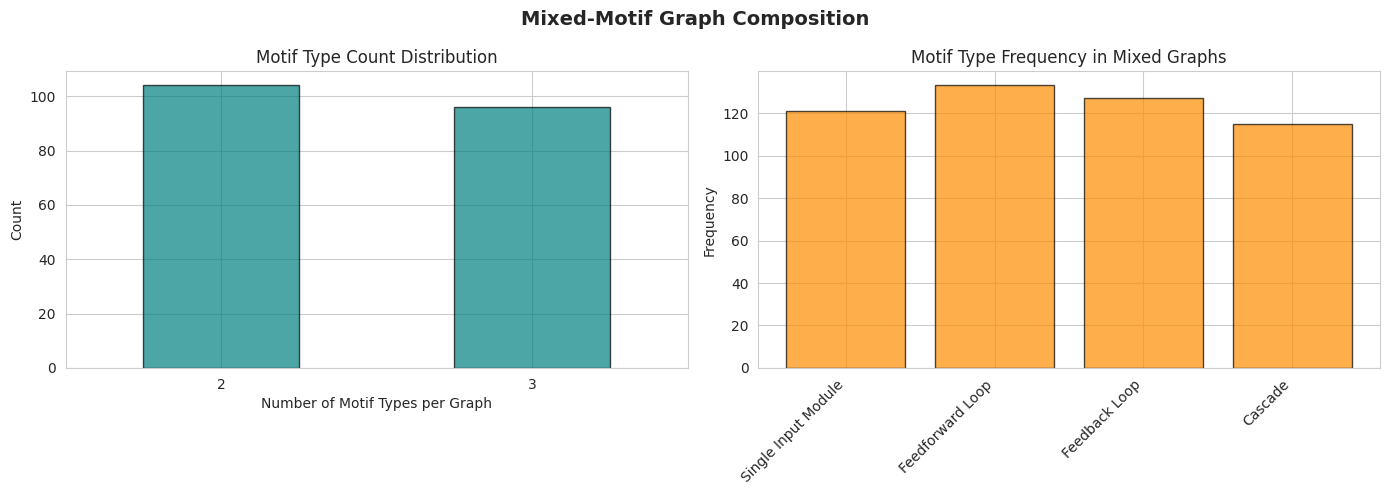


Composition Statistics:
  2 motif types: 104 graphs
  3 motif types: 96 graphs

Motif frequency: {'single_input_module': 121, 'feedforward_loop': 133, 'feedback_loop': 127, 'cascade': 115}


In [115]:
composition_lengths = [len(comp) for comp in mixed_compositions]
all_motifs_in_mixed = [motif for comp in mixed_compositions for motif in comp]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pd.Series(composition_lengths).value_counts().sort_index().plot(kind='bar', 
                                                                ax=axes[0],
                                                                color='teal',
                                                                edgecolor='black',
                                                                alpha=0.7)
axes[0].set_xlabel('Number of Motif Types per Graph')
axes[0].set_ylabel('Count')
axes[0].set_title('Motif Type Count Distribution')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

motif_counts = Counter(all_motifs_in_mixed)
motif_names = [m.replace('_', ' ').title() for m in motif_counts.keys()]
axes[1].bar(motif_names, motif_counts.values(), color='darkorange', edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Frequency')
axes[1].set_title('Motif Type Frequency in Mixed Graphs')
axes[1].set_xticklabels(motif_names, rotation=45, ha='right')

plt.suptitle('Mixed-Motif Graph Composition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nComposition Statistics:")
print(f"  2 motif types: {composition_lengths.count(2)} graphs")
print(f"  3 motif types: {composition_lengths.count(3)} graphs")
print(f"\nMotif frequency: {dict(motif_counts)}")

## Mixed Graph Visualizations

/tmp/ipykernel_3495417/3054460694.py:32: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/3054460694.py:32: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/3054460694.py:32: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/3054460694.py:32: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
/tmp/ipykernel_3495417/3054460694.py:32: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and wil

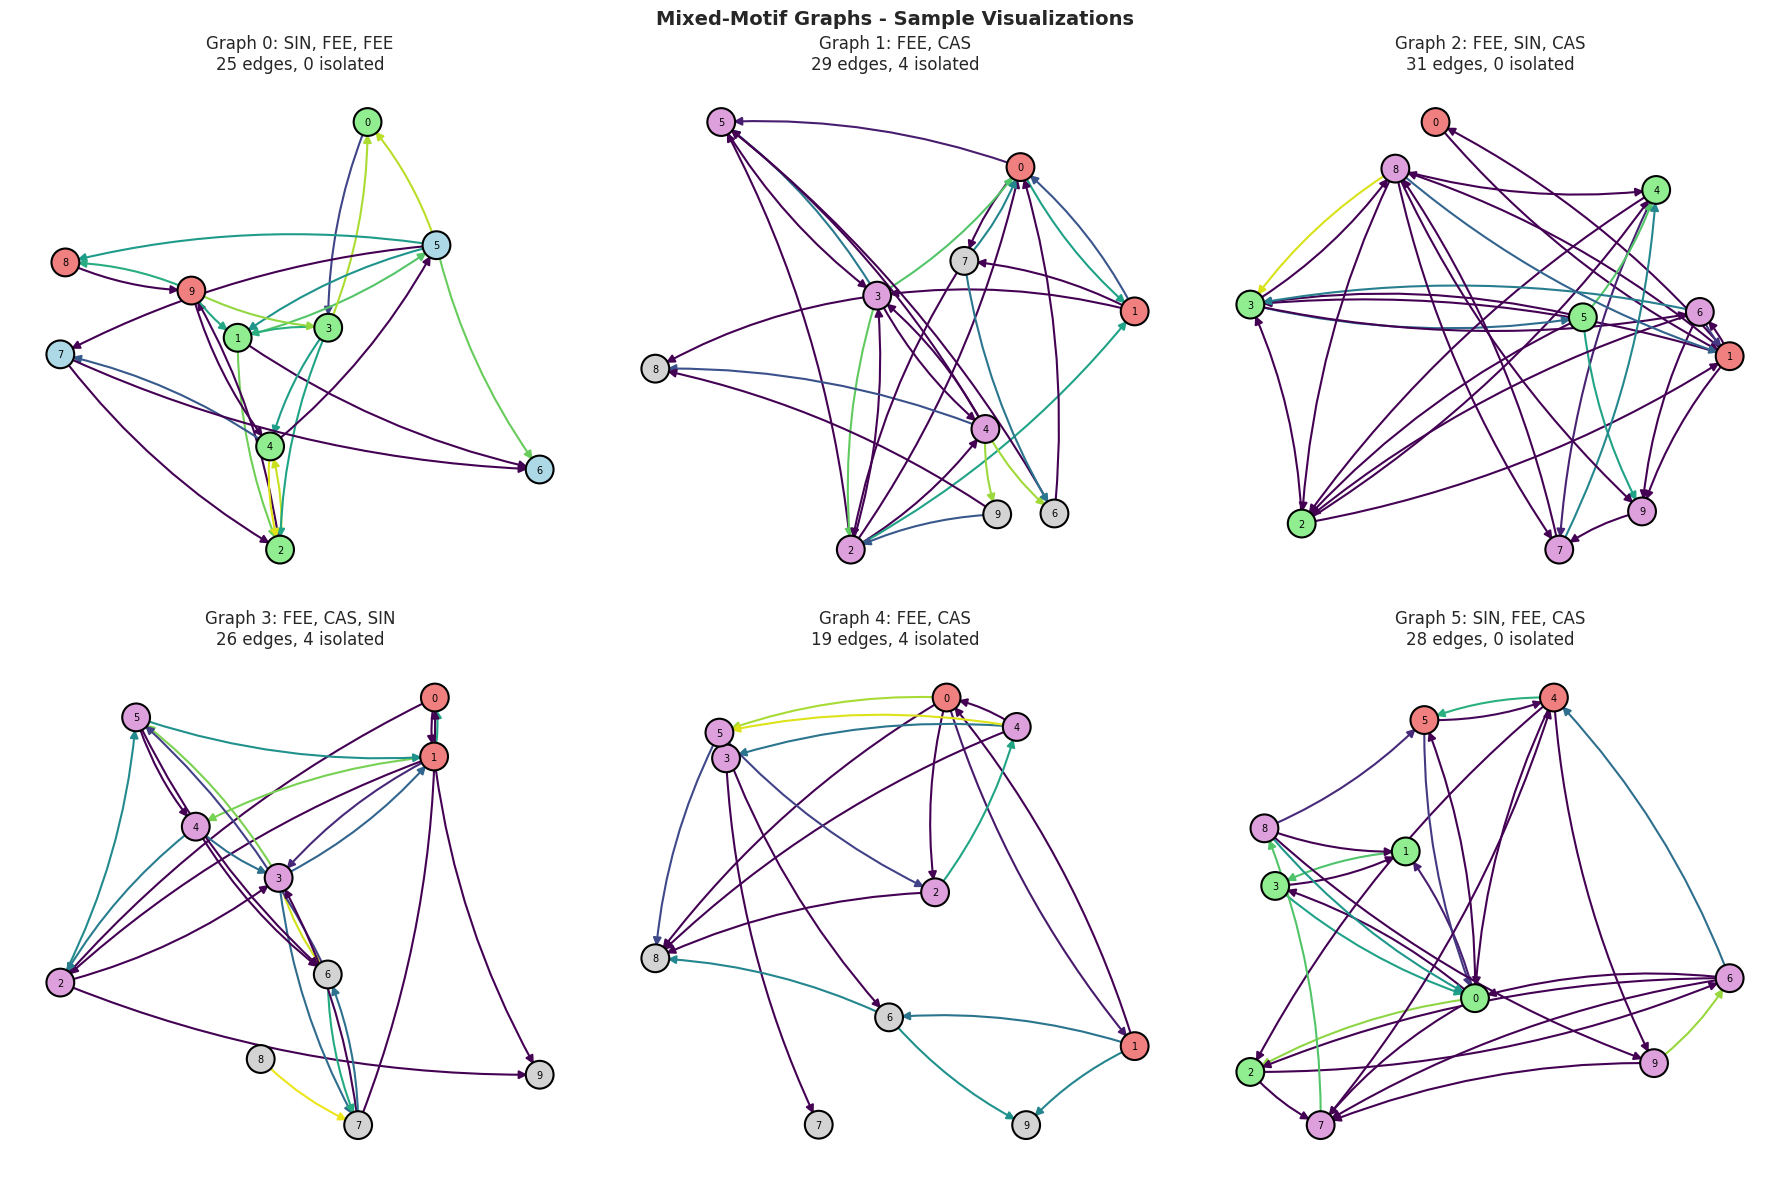

In [116]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx in range(6):
    if idx < len(mixed_graphs):
        G = mixed_graphs[idx]
        meta = mixed_metadata[idx]
        comp = mixed_compositions[idx]
        
        pos = nx.spring_layout(G, seed=42, k=0.7)
        
        node_colors = []
        for i in range(len(G.nodes())):
            if meta.iloc[i].sum() == 0:
                node_colors.append('lightgray')
            elif meta.iloc[i]['feedforward_loop'] == 1:
                node_colors.append('lightblue')
            elif meta.iloc[i]['feedback_loop'] == 1:
                node_colors.append('lightcoral')
            elif meta.iloc[i]['single_input_module'] == 1:
                node_colors.append('lightgreen')
            elif meta.iloc[i]['cascade'] == 1:
                node_colors.append('plum')
            else:
                node_colors.append('yellow')
        
        edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
        
        nx.draw_networkx_nodes(G, pos, node_size=400, node_color=node_colors,
                              edgecolors='black', linewidths=1.5, ax=axes[idx])
        
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                              edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1,
                              width=1.5, arrows=True, arrowsize=12,
                              connectionstyle='arc3,rad=0.1', ax=axes[idx])
        
        nx.draw_networkx_labels(G, pos, font_size=7, ax=axes[idx])
        
        comp_str = ', '.join([c[:3].upper() for c in comp])
        isolated = (meta.sum(axis=1) == 0).sum()
        axes[idx].set_title(f'Graph {idx}: {comp_str}\n{len(G.edges())} edges, {isolated} isolated')
        axes[idx].axis('off')

plt.suptitle('Mixed-Motif Graphs - Sample Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Mixed Graph Statistics

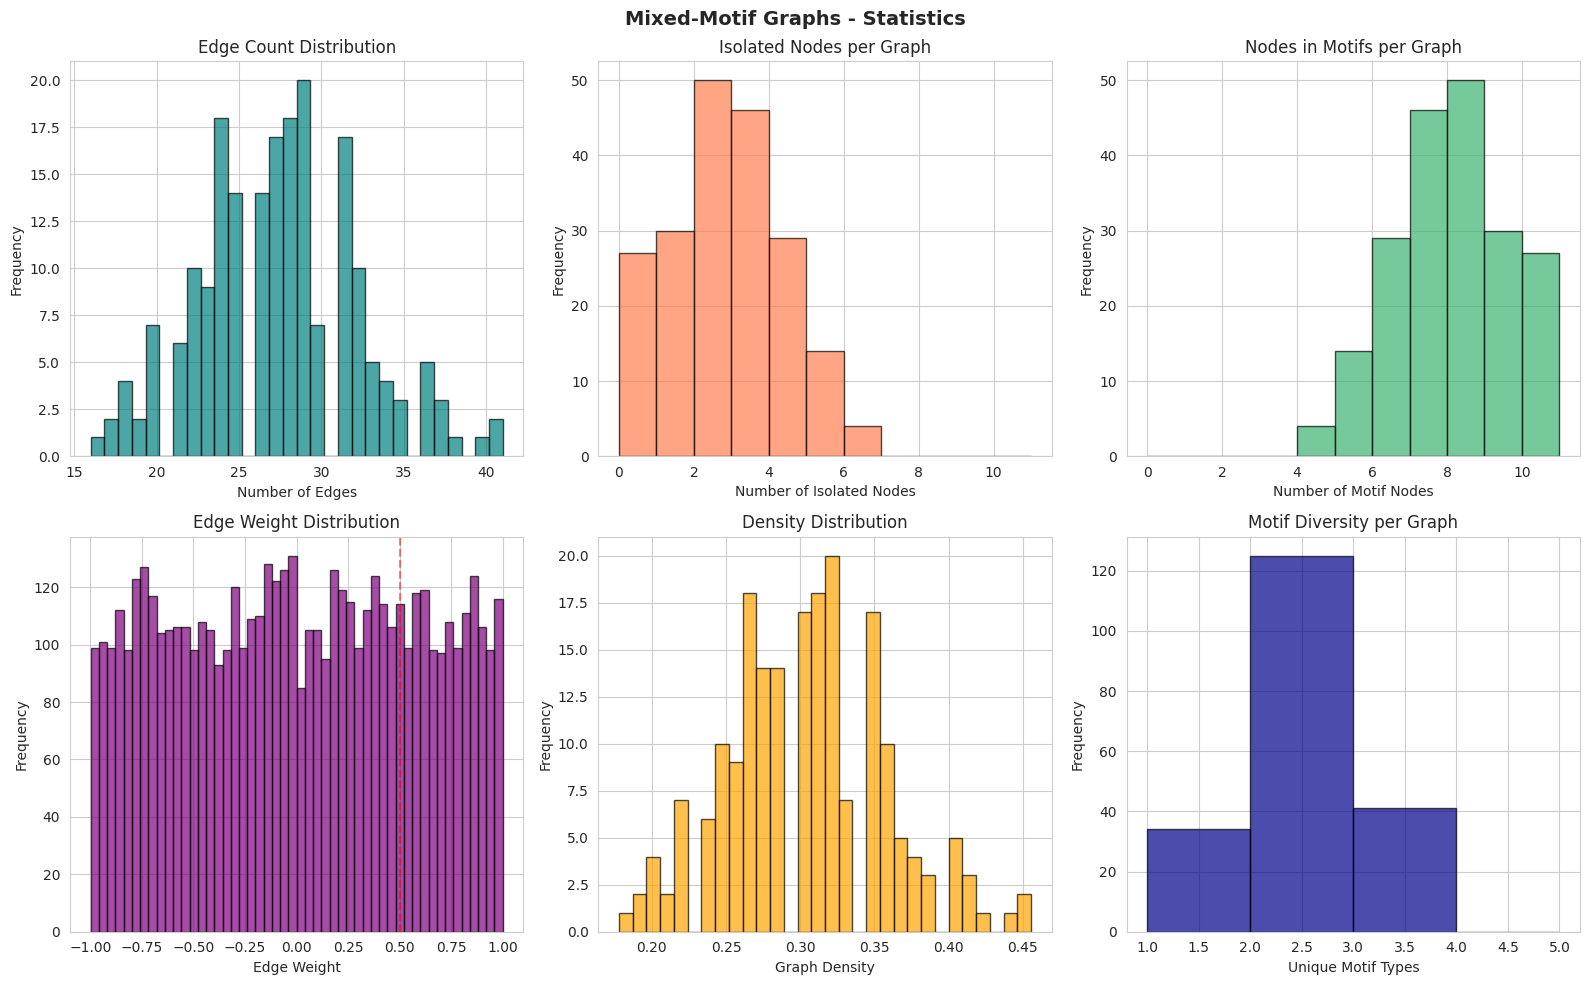

In [117]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].hist(mixed_stats['num_edges'], bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[0, 0].set_xlabel('Number of Edges')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Edge Count Distribution')

axes[0, 1].hist(mixed_stats['isolated_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Number of Isolated Nodes')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Isolated Nodes per Graph')

axes[0, 2].hist(mixed_stats['motif_nodes'], bins=range(12), edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[0, 2].set_xlabel('Number of Motif Nodes')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Nodes in Motifs per Graph')

axes[1, 0].hist(mixed_stats['edge_weights'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_xlabel('Edge Weight')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Edge Weight Distribution')
axes[1, 0].axvline(0.5, color='red', linestyle='--', alpha=0.5)

axes[1, 1].hist(mixed_stats['density'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Graph Density')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Density Distribution')

motif_diversity = [len(set(comp)) for comp in mixed_compositions]
axes[1, 2].hist(motif_diversity, bins=range(1, 6), edgecolor='black', alpha=0.7, color='darkblue')
axes[1, 2].set_xlabel('Unique Motif Types')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Motif Diversity per Graph')

plt.suptitle('Mixed-Motif Graphs - Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Expression Dynamics for Mixed Graphs

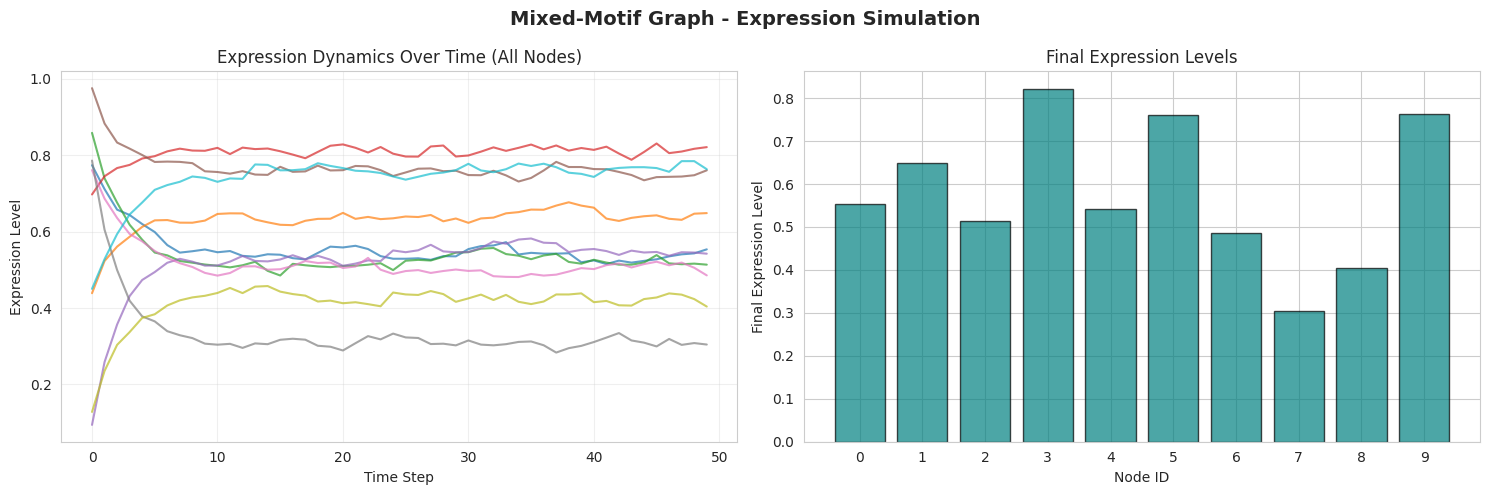

In [118]:
sample_mixed_G = mixed_graphs[0]
W_mixed = nx.to_numpy_array(sample_mixed_G, weight='weight')
final_expr_mixed, trajectory_mixed = simulate_expression(W_mixed, steps=50)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for node in range(len(final_expr_mixed)):
    axes[0].plot(trajectory_mixed[:, node], linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Expression Level')
axes[0].set_title('Expression Dynamics Over Time (All Nodes)')
axes[0].grid(alpha=0.3)

axes[1].bar(range(len(final_expr_mixed)), final_expr_mixed, color='teal', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Node ID')
axes[1].set_ylabel('Final Expression Level')
axes[1].set_title('Final Expression Levels')
axes[1].set_xticks(range(len(final_expr_mixed)))

plt.suptitle('Mixed-Motif Graph - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Single vs Mixed Comparison

Direct comparison between single-motif and mixed-motif graphs.

In [119]:
single_data = []
for motif_type, stats in all_single_motif_stats.items():
    for i in range(min(50, len(stats['num_edges']))):
        single_data.append({
            'type': 'Single',
            'num_edges': stats['num_edges'][i],
            'isolated_nodes': stats['isolated_nodes'][i],
            'density': stats['density'][i]
        })

mixed_data = []
for i in range(min(50, len(mixed_stats['num_edges']))):
    mixed_data.append({
        'type': 'Mixed',
        'num_edges': mixed_stats['num_edges'][i],
        'isolated_nodes': mixed_stats['isolated_nodes'][i],
        'density': mixed_stats['density'][i]
    })

comparison_df_all = pd.DataFrame(single_data + mixed_data)

/tmp/ipykernel_3495417/2510044693.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_df_all, x='type', y='num_edges', ax=axes[0], palette='Set2')
/tmp/ipykernel_3495417/2510044693.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_df_all, x='type', y='isolated_nodes', ax=axes[1], palette='Set2')
/tmp/ipykernel_3495417/2510044693.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=comparison_df_all, x='type', y='density', ax=axes[2], palette='Set2')


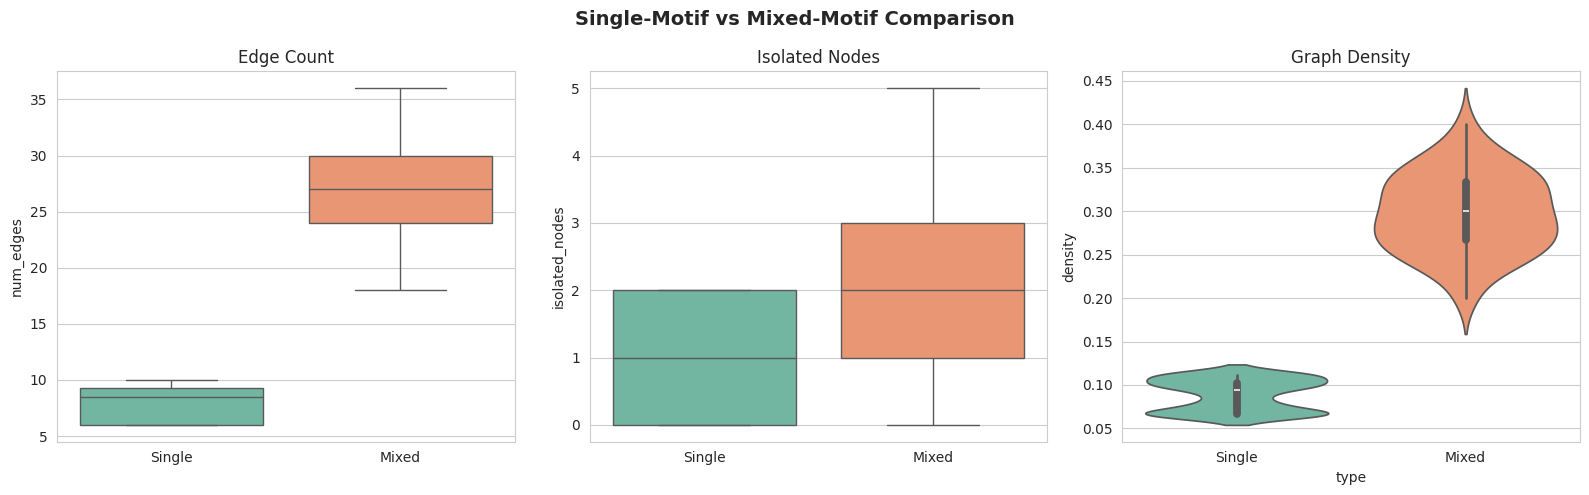

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.boxplot(data=comparison_df_all, x='type', y='num_edges', ax=axes[0], palette='Set2')
axes[0].set_title('Edge Count')
axes[0].set_xlabel('')

sns.boxplot(data=comparison_df_all, x='type', y='isolated_nodes', ax=axes[1], palette='Set2')
axes[1].set_title('Isolated Nodes')
axes[1].set_xlabel('')

sns.violinplot(data=comparison_df_all, x='type', y='density', ax=axes[2], palette='Set2')
axes[2].set_title('Graph Density')

plt.suptitle('Single-Motif vs Mixed-Motif Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [121]:
print("\nSingle vs Mixed Statistics:")
print(comparison_df_all.groupby('type').agg({
    'num_edges': ['mean', 'std', 'min', 'max'],
    'isolated_nodes': ['mean', 'std'],
    'density': ['mean', 'std']
}).round(4))


Single vs Mixed Statistics:
       num_edges                 isolated_nodes         density        
            mean     std min max           mean     std    mean     std
type                                                                   
Mixed     26.800  4.0658  18  36          2.120  1.4090  0.2978  0.0452
Single     8.005  1.6273   6  10          0.995  0.8051  0.0889  0.0181


---
# Summary and Conclusions

In [122]:
print("="*60)
print("10-NODE GRAPH DATASET SUMMARY")
print("="*60)
print(f"\nTotal Graphs Analyzed: {n_graphs}")
print(f"\nGraph Structure:")
print(f"  - All graphs have exactly 10 nodes")
print(f"  - Single-motif graphs: Multiple instances of same motif type")
print(f"  - Mixed-motif graphs: 2-3 different motif types")
print(f"  - Isolated nodes allowed (not in any motif)")
print(f"\nEdge Properties:")
print(f"  - All edge weights in [0, 1] range")
print(f"  - Mixed graphs have additional random edges (20-30% probability)")
print(f"\nMetadata:")
print(f"  - Binary indicators for each motif type per node")
print(f"  - Isolated nodes have all 0s")
print(f"  - One metadata CSV per graph")
print("="*60)

10-NODE GRAPH DATASET SUMMARY

Total Graphs Analyzed: 5000

Graph Structure:
  - All graphs have exactly 10 nodes
  - Single-motif graphs: Multiple instances of same motif type
  - Mixed-motif graphs: 2-3 different motif types
  - Isolated nodes allowed (not in any motif)

Edge Properties:
  - All edge weights in [0, 1] range
  - Mixed graphs have additional random edges (20-30% probability)

Metadata:
  - Binary indicators for each motif type per node
  - Isolated nodes have all 0s
  - One metadata CSV per graph
